**Adapted Linear Threshold Model**

*Ana Sophia Rashid-Cocker, Mar 2025, Tardif Lab*

This notebook contains code for a single seed LTM, as well as a competitive linear threshold model where the number of initial seeds can be tuned. The code follows the models described in  [Misic et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/26087168/).  
Key functions:


*   linear_threshold_model()
*   competitive_linear_threshold_model()



For the competitive LTM, there is an option to modify nodal thresholds (eg. using T1 values) See: Heterogeneous model.  

Functional connectivity can also be predicted from the LTM using by building association weight matrices from numerous combinations of random seeds in a competitive LTM (Misic et al., 2015).
Key functions:


*   generate_seeds()
*   run_simulations()
*   compute_assoction_matrix()
*   seed_comparison()





In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
random.seed(42)

import seaborn as sns
import os

#Graph theory tools
import networkx as nx

#Statistical tools
from scipy.stats import zscore

**Loading in data**

Here we mount the google drive to load in structural connectivity matrices (200x200 csvs), as well as cortical-level data (eg. MTSat values) which will be used to modulate nodal thresholds.

*Paths must be changed for external use.*

In [3]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

#Load in Functional Connectivity matrix
path = "/content/drive/My Drive/group_FC.csv"
group_FCdf = pd.read_csv(path, header=None) #build a FC dataframe

#Load in Structural connectivity matrix (binary version)
path = "/content/drive/My Drive/bin_NoS.csv"
binary_NoSdf= pd.read_csv(path, header=None)

#Load in weighted Structural connectivity matrix (NoS)
path = "/content/drive/My Drive/NoS.csv"
NoSdf= pd.read_csv(path, header=None)

#Load in cortical-level data (group averaged)
path = "/content/drive/My Drive/averaged_schaefer-200.csv"
averaged_schaeferdf = pd.read_csv(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Linear Threshold Model - 1 seed**

Default threshold varies between even and odd nodes for visualization purposes, rule can be changed by modfiying set_threshold()

In [ ]:
def set_threshold(node):
  '''
  Assigns a threshold value based on whether the node is even or odd.
  Parameters:
  - node: Node within networkx Digraph
  Returns:
  - Threshold: 2 if even, 1 if odd
  '''
  if node % 2 == 0:
    return 2
  else:
    return 1

def linear_threshold_model(G, seed_nodes, thresholds=None, max_steps=10):
    """
    Simulates the Linear Threshold Model (LTM) on a directed graph.

    Parameters:
    - G: networkx DiGraph, directed graph representing the network
    - seed_nodes: list, initial active nodes
    - thresholds: dict, node-specific thresholds (default: 2 if even node, else 1)
    - max_steps: int, maximum number of iterations to prevent infinite loops

    Returns:
    - active_nodes: set, final set of active nodes
    """

    # Initialize node thresholds randomly if not provided
    if thresholds is None:
        thresholds = {node: set_threshold(node) for node in G.nodes()}

    # Set initial active nodes
    active_nodes = set(seed_nodes)

    for _ in range(max_steps):
        new_activations = set()

        for node in G.nodes():
            if node in active_nodes:
                continue  # Skip already active nodes

            # Get active neighbors and compute activation proportion
            active_neighbors = [n for n in G.predecessors(node) if n in active_nodes]
            activation_score = sum(G[n][node]['weight'] for n in active_neighbors)

            if activation_score >= thresholds[node]:
                new_activations.add(node)

        if not new_activations:
            break  # Stop if no new activations

        active_nodes.update(new_activations)
        print(active_nodes)

        # Create a list of colors based on whether the node is active or not
        node_colors = ['red' if node in active_nodes else 'lightblue' for node in G.nodes()]

        plt.figure(figsize=(6, 6))
        pos = nx.spring_layout(G, seed = 42)
        nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=700, font_size=12)
        plt.show()

    return active_nodes


**Competitive Linear Threshold Model**

Number of competitive cascades across the network = number of random seeds. Once a node has a threshold number of neighbours active (all belonging to the same cascade) it too becomes an active part of that cascade. Ties occur when there is an equal number of neighbouring activated nodes for more than one cascade at a certain time point. We resolve these cascades randomly, but this can be tweaked within competitive_linear_threshold_model().

*You may want to comment out plots when tuning competitive LTM*

In [16]:

def competitive_linear_threshold_model(G, seed_groups, max_steps = 10, thresholds=None):
  '''
  Initiates competitive cascades starting at nodes within seed groups, and continues until max_steps exceeded or no
  new nodes are activated.

  Parmeters:
  - G: networkx DiGraph, directed graph representing the network
  - seed_nodes: list, initial active nodes
  - thresholds: dict, node-specific thresholds (default: 2 if even node, else 1)
  - max_steps: int, maximum number of iterations to prevent infinite loops

  Returns:
  - active_nodes: set, final set of active nodes
  '''

  if thresholds is None:
    thresholds = {node: 1 for node in G.nodes()} #proportion of neighbours defined in Misic et al. (2015) - change back to 0.008
  else:
    node_list = list(G.nodes())  # Get node order
    thresholds = {node: thresholds[i] for i, node in enumerate(node_list)}

  # Initialize active nodes for each group
  active_nodes = {group: set(nodes) for group, nodes in seed_groups.items()}

  # Generate unique colors dynamically using a colormap - for graph visualization
  num_groups = len(seed_groups)
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed
  group_colors = {group: cmap(i) for i, group in enumerate(seed_groups)}

  #plot initial state before propagation (for visualization purposes)

  node_colors = {node: 'black' for node in G.nodes()}  # Default color
  for group in seed_groups:
      for node in active_nodes[group]:
          node_colors[node] = group_colors[group]  # Assign group colors to seed nodes

  plt.figure(figsize=(6, 6))
  pos = nx.spring_layout(G, seed=42)
  nx.draw(G, pos, with_labels=True, node_color=[node_colors[n] for n in G.nodes()], edge_color='gray',
          node_size=700, font_size=12)
  plt.title("t1: Initial Seed Nodes")
  plt.show()




  #signal propagation process
  for _ in range(max_steps):
      random.seed(42)
      new_activations = {group: set() for group in seed_groups}

      for node in G.nodes():
          if any(node in active for active in active_nodes.values()):
              continue  # Skip already active nodes

          # Compute activation scores for each group
          activation_scores = {group: sum(G[n][node]['weight'] for n in active_nodes[group] if n in G.predecessors(node))
                                for group in seed_groups}

          # Find the group(s) with the highest activation score
          max_score = max(activation_scores.values(), default=0)
          if max_score == 0:
              continue  # No activation possible

          best_groups = [group for group, score in activation_scores.items() if score == max_score and score >= thresholds[node]]

          if best_groups:
              chosen_group = random.choice(best_groups)  # Resolve ties randomly
              new_activations[chosen_group].add(node)

      # Stop if no new activations
      if all(not new for new in new_activations.values()):
          break

      # Update active nodes
      for group in seed_groups:
          active_nodes[group].update(new_activations[group])



      # Visualization

      node_colors = {node: 'black' for node in G.nodes()}  # Default color
      for group in seed_groups:
          for node in active_nodes[group]:
              node_colors[node] = group_colors[group]  # Assign color based on group

      plt.figure(figsize=(6, 6))
      pos = nx.spring_layout(G, seed=42)
      nx.draw(G, pos, with_labels=True, node_color=[node_colors[n] for n in G.nodes()], edge_color='gray',
              node_size=700, font_size=12)
      plt.show()



  return active_nodes


**Competitive LTM Demonstration**

In [ ]:
adj_matrix = np.random.randint(0, 2, (30, 30)) #Initialize a matrix
np.fill_diagonal(adj_matrix, 0)  # No self-loops (diagonal elements are 0)
adj_matrix = np.triu(adj_matrix) + np.triu(adj_matrix, 1).T  # Make it symmetric

G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph()) #convert matrix into graph

#Eg. 4 inital groups of seeds ie. 4 different cascades with seed groups indicated
seed_groups = {'Group 1': [0], 'Group 2': [2], 'Group 3': [4], 'Group 4': [11]}

#Print all the initially active nodes by iterating through the groups and printing keys
print("Initial active nodes:")
for group, nodes in seed_groups.items():
    print(f"{group}: {nodes}")

#Call the competitive linear threshold model function
final_active_nodes = competitive_linear_threshold_model(G, seed_groups)

print("Final active nodes:")
for group, nodes in final_active_nodes.items():
    print(f"{group}: {nodes}")


**The following code is for predicting FC from competitive linear threshold model: **


*   generate_seeds: randomly samples initial seeds
*   run_simulations: runs competitive LTM and saves final activations to build association weight matrix

*   compute_association_matrix: builds association matrix from final activations.
*   plot_association_matrix: used for visualization





In [6]:
#Combining steps

#Generate different combinations of seeds
def generate_seeds(G, x, y):
  '''G is graph, x is number of groups (starting seeds), y is number of configurations'''
  nodes = list(G.nodes)
  seed_groups_list = []

  #Sampling with replacement is ok - we are trying different combinations
  for _ in range(y):
    sampled_nodes = random.sample(nodes, x) #pick x unique nodes
    seed_groups = {f'Group{i+1}': {sampled_nodes[i]} for i in range(x)}
    seed_groups_list.append(seed_groups)

  return seed_groups_list

#Running multiple simulations
def run_simulations(G, x, y, max_steps =10, thresholds=None):
  '''G is graph, x is number of seeds per y configurations'''
  seed_groups_list = generate_seeds(G, x, y) #generate seeds
  final_activations = []

  for i, seed_groups in enumerate(seed_groups_list):
    #print(f"\n### Running Simulation {i+1}/{y} ###\n")
    final_active_nodes = competitive_linear_threshold_model(G, seed_groups, max_steps=10, thresholds=thresholds)
    final_activations.append(final_active_nodes)

  return final_activations


In [17]:
from typing_extensions import final
#Computing Association weight matrices

def compute_association_matrix(G, final_activations):
  '''
  Constructs an association matrix, vertices are nodes in graph and edges are the
  number of times two nodes were activated in the same cascade.

  Parameters:
  - G: networkx DiGraph, directed graph representing the network
  - final_activations: List of lists of final active nodes belonging to each cascade

  Returns:
  - association matrix: 2D numpy array
  '''
  nodes = list(G.nodes())
  node_index = {node: i for i, node in enumerate(nodes)}
  N = len(nodes)

  #init empty association matrix
  association_matrix = np.zeros((N, N), dtype=int)

  #iterate through each final activation configuration
  for activation in final_activations:
    for group in activation.values(): #activation is a subdictionary
      group_nodes = list(group)
      for i in range(len(group_nodes)):
        for j in range(i+1, len(group_nodes)):
          node1 = group_nodes[i]
          node2 = group_nodes[j]
          index1 = node_index[node1]
          index2 = node_index[node2]
          association_matrix[index1, index2] += 1
          association_matrix[index2, index1] += 1
  return association_matrix


def plot_association_matrix(association_matrix, G):
  '''
  VIsualization for association matrix.
  Parameters:
  - association_matrix: 2D numpy array
  - G: networkx DiGraph, directed graph representing the network
  Returns:
  - None
  '''
  # Set up the node labels (ordered by the node list)
  nodes = list(G.nodes())

  plt.figure(figsize=(8, 6))

  # Plotting the heatmap
  sns.heatmap(association_matrix,
              annot=False,  # Annotate with the matrix values
              cmap='viridis_r',  #
              fmt='d',  # Format annotation as integer
              linewidths=0,  # Line width between cells
              cbar_kws={'label': 'Co-occurrence Frequency'})  # Colorbar label

  plt.title('Node Association Matrix', fontsize=16)
  #plt.xticks(rotation=90)  # Rotate x labels for better readability
  #plt.yticks(rotation=0)   # Rotate y labels for better readability
  plt.tight_layout()  # Adjust layout to fit labels

  plt.show()



**Demo: Running Simulations to build assocation weight matrix**

In [ ]:
#adj_matrix = np.random.randint(0, 2, (30, 30)) #randomly initialize matrix

#Make this graph more sparse
adj_matrix = np.random.randint(0, 2, (5, 5)) #randomly initialize matrix
np.fill_diagonal(adj_matrix, 0)  # No self-loops (diagonal elements are 0)
adj_matrix = np.triu(adj_matrix) + np.triu(adj_matrix, 1).T  # Make it symmetric
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph()) #turn matrix into graph

#make a threshold list 1 if even index 2 if odd
#thresholds_list = [2 if i % 2 == 0 else 1 for i in range(30)]

#Mock simulations
final_activations = run_simulations(G, 2, 2, max_steps = 10, thresholds=None)
#Testing association matrix computations
association_matrix = compute_association_matrix(G, final_activations)
plot_association_matrix(association_matrix, G)



*   pearson_correlation: for computing correlations between association weight matrices and empirical FC
*   seed_comparison: For testing y configurations of x random seeds, and seeing which combination yields closest correlation to empirical FC.



In [27]:
def pearson_correlation(matrix1, matrix2):
  '''
  Computes upper triangular correlation between 2 input matrices (same size)
  Parameters:
  - matrix1: 2D numpy array
  - matrix2: 2D numpy array
  Returns:
  - r: float
  '''
  A = np.array(matrix1)
  B = np.array(matrix2)

  # Extract the upper triangle (excluding the diagonal)
  A_upper = A[np.triu_indices(A.shape[0], k=1)]
  B_upper = B[np.triu_indices(B.shape[0], k=1)]

  # Calculate the Pearson correlation coefficient
  r = np.corrcoef(A_upper, B_upper)[0, 1]  # Extract the off-diagonal element

  return r

def seed_comparison(G, FC_matrix, y, x_range_start, x_range_end, thresholds=None):
  r_values = [] #store all of the pearson correlation values
  max_r_value = 0
  best_seed_num = 0

  #Run simulation from x=0-> 50
  for x in range(x_range_start, x_range_end):
    final_activations = run_simulations(G, x, y, thresholds=thresholds) #changed this to se thresholds
    association_matrix = compute_association_matrix(G, final_activations)
    #plot_association_matrix(association_matrix, G) take out the plot assocation matrix for now
    r_val = pearson_correlation(FC_matrix, association_matrix)
    r_values.append(r_val)
    if r_val > max_r_value:
      max_r_value = r_val
      best_seed_num = x

  #temporary change to return r-value
  print(max_r_value)
  print(best_seed_num)


  #Plot r values as a function of x
  x_values = list(range(x_range_start, x_range_end))
  print(x_values)
  print(r_values)
  print(max_r_value)
  print(best_seed_num)


  plt.plot(x_values, r_values, marker='o')
  plt.xlabel('Number of seeds')
  plt.ylabel('Pearson Correlation')
  plt.title('Pearson Correlation vs. Number of Seeds')
  plt.grid(True)
  plt.show()

  return max_r_value


The following code blocks test the model performance as well as the effect of modulating nodal thresholds at both the whole-brain and hemispheric level.

**Homogenous Model Fitting**

In [ ]:
#Whole Brain level weighted structural connectivity matrix

#Weighted NoS data frame
adj_matrix = np.array(NoSdf) #this is a weighted adjacency matrix

#Standardize and Z-score the data
adj_matrix_zscore = (adj_matrix - np.mean(adj_matrix)) / np.std(adj_matrix)

#Turn the binarized array into a graph
G = nx.from_numpy_array(adj_matrix_zscore, create_using=nx.DiGraph())

#Turn the FC dataframe into a numpy array
FC_matrix = np.array(group_FCdf)

#Test with seed comparisons
#seed_comparison(G, FC_matrix, 100, 2, 50, thresholds=None) #test between having 2 and 50 seeds


<ipython-input-4-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


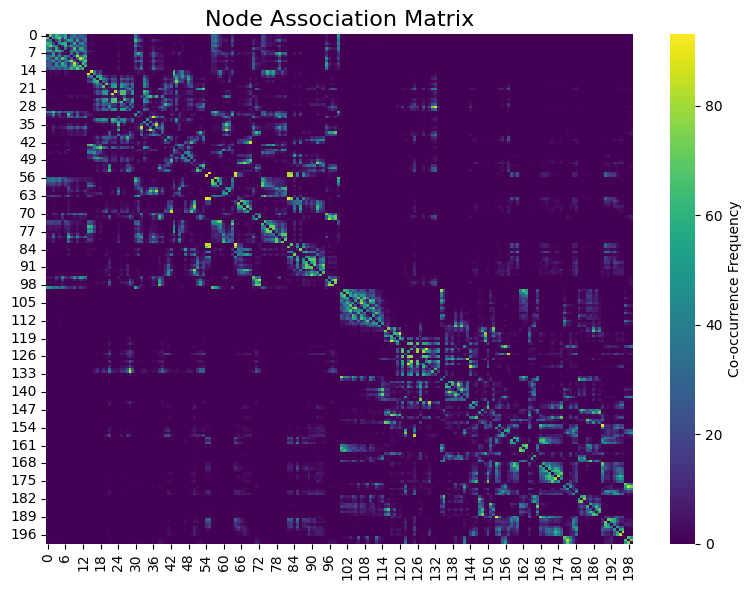

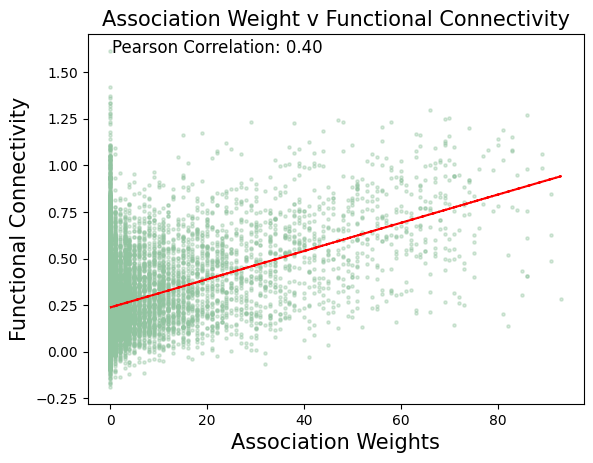

In [ ]:
from scipy.stats import pearsonr
#Association weight values
final_activations = run_simulations(G, 35, 100, thresholds=None)
association_matrix = compute_association_matrix(G, final_activations)
plot_association_matrix(association_matrix, G)

#Plot scatterplot between values in the association matrix and FC_matrix_LH
x = association_matrix.flatten()
y = FC_matrix.flatten()

#Compute the Pearson correlation
corr, _ = pearsonr(x, y)

#Create a scatter plot
plt.scatter(x, y, alpha=0.2, s=5, color='#91c4a0')
#Add a line of best fit and pearson correlation value
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

#print pearson correlation value on graph
plt.text(0.05, 0.95, f'Pearson Correlation: {corr:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('Association Weights', fontsize=15)
plt.ylabel('Functional Connectivity', fontsize=15)
plt.title('Association Weight v Functional Connectivity', fontsize=15)
plt.show()


**Homogeneous Model: Hemispheric Level**

In [ ]:
#Left Hemisphere Homogenous Model

#Extract LH adjacency matrix and FC
adj_matrix= np.array(NoSdf)
FC_matrix = np.array(group_FCdf)

#Splice adj matrix to have only first 100 values
adj_matrix_LH = adj_matrix[:100, :100]
FC_matrix_LH = FC_matrix[:100, :100]

adj_matrix_zscore_LH = (adj_matrix_LH - np.mean(adj_matrix_LH)) / np.std(adj_matrix_LH)

#Turn the binarized array into a graph
G = nx.from_numpy_array(adj_matrix_LH, create_using=nx.DiGraph())

seed_comparison(G, FC_matrix_LH, 100, 2, 50, thresholds=None)

<ipython-input-4-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


KeyboardInterrupt: 

In [ ]:
#Left Hemisphere Homogeneous Model

#Association weight values
final_activations = run_simulations(G, 16, 100, thresholds=None)
association_matrix = compute_association_matrix(G, final_activations)
plot_association_matrix(association_matrix, G)

#Plot scatterplot between values in the association matrix and FC_matrix_LH
x = association_matrix.flatten()
y = FC_matrix_LH.flatten()

#Compute the Pearson correlation
corr, _ = pearsonr(x, y)

#Create a scatter plot
plt.scatter(x, y, alpha=0.5)
#Add a line of best fit and pearson correlation value
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

#print pearson correlation value on graph
plt.text(0.05, 0.95, f'Pearson Correlation: {corr:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('Association Weights')
plt.ylabel('Functional Connectivity')
plt.title('Association Weight v Functional Connectivity')
plt.show()


<ipython-input-4-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


KeyboardInterrupt: 

<ipython-input-6-9b9a7279c3bd>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


0.5201544451762959
22
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[np.float64(0.3410274244742202), np.float64(0.39427311840835855), np.float64(0.40850775588843524), np.float64(0.43612355201846487), np.float64(0.46240961724906493), np.float64(0.4587870109541416), np.float64(0.4623793088156483), np.float64(0.479133388371293), np.float64(0.484550947917263), np.float64(0.49924531579283093), np.float64(0.49999948041704123), np.float64(0.5036478635879154), np.float64(0.5070323651223819), np.float64(0.5125767229159306), np.float64(0.5123033244653317), np.float64(0.5083137485918702), np.float64(0.5192844549491175), np.float64(0.5120113686660092), np.float64(0.5147350148281435), np.float64(0.5112067479414394), np.float64(0.5201544451762959), np.float64(0.5180287796084404), np.float64(0.511699009815909), np.float64(0.5086904958578026), np.float64(0.51521722

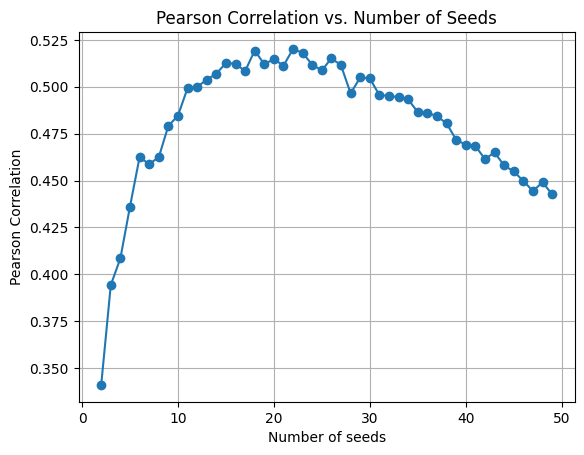

np.float64(0.5201544451762959)

In [ ]:
#Right Hemisphere Homogeneous Model

#Extract RH adjacency matrix and FC
adj_matrix= np.array(NoSdf)
FC_matrix = np.array(group_FCdf)

#Splice adj matrix to have only last 100 values
adj_matrix_RH = adj_matrix[-100:, -100:]
FC_matrix_RH = FC_matrix[-100:, -100:]

adj_matrix_zscore_RH = (adj_matrix_RH - np.mean(adj_matrix_RH)) / np.std(adj_matrix_RH)

#Turn the binarized array into a graph
G = nx.from_numpy_array(adj_matrix_RH, create_using=nx.DiGraph())

seed_comparison(G, FC_matrix_RH, 100, 2, 50, thresholds=None)

<ipython-input-6-9b9a7279c3bd>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


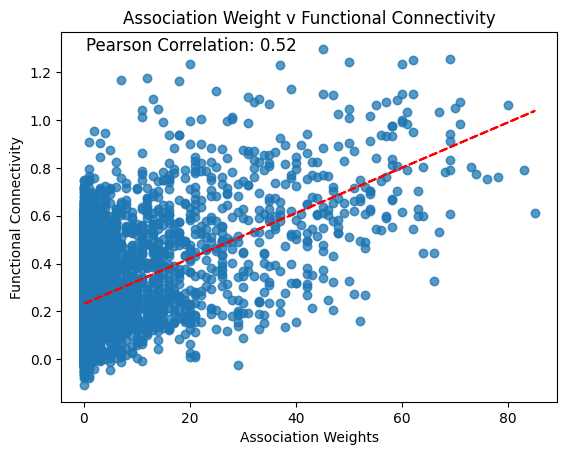

In [ ]:
#Right Hemisphere Homogenous model

#Association weight values
final_activations = run_simulations(G, 22, 100, thresholds=None)
association_matrix = compute_association_matrix(G, final_activations)
plot_association_matrix(association_matrix, G)

#Plot scatterplot between values in the association matrix and FC_matrix_LH
x = association_matrix.flatten()
y = FC_matrix_RH.flatten()

#Compute the Pearson correlation
corr, _ = pearsonr(x, y)

#Create a scatter plot
plt.scatter(x, y, alpha=0.5)
#Add a line of best fit and pearson correlation value
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

#print pearson correlation value on graph
plt.text(0.05, 0.95, f'Pearson Correlation: {corr:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('Association Weights')
plt.ylabel('Functional Connectivity')
plt.title('Association Weight v Functional Connectivity')
plt.show()


**Ex: Heterogeneous Model: Thresholds set by T1 values**

In [ ]:
#Extract and normalize T1 values

R1_values = averaged_schaeferdf['Mean R1'].values
T1_values = 1/R1_values

#Weighted NoS data frame
adj_matrix = np.array(NoSdf) #this is a weighted adjacency matrix

#Z-score
adj_matrix_zscore = (adj_matrix - np.mean(adj_matrix)) / np.std(adj_matrix)

#Redefine FC matrix
FC_matrix = np.array(group_FCdf)

#Turn the weighted association matrix into a graph
G = nx.from_numpy_array(adj_matrix_zscore, create_using=nx.DiGraph())

#Normalize T1 data
T1_min = T1_values.min()
T1_max = T1_values.max()
normalized_T1 = (T1_values - T1_min) / (T1_max - T1_min)

**Using grid search to scale T1 values: Linear + Sigmoid**

#### TESTING A VALUE: 0.5 ##########
#### TESTING B VALUE: 0 ##########
-0.5
#### TESTING A VALUE: 0.5 ##########
#### TESTING B VALUE: 1 ##########
0.5
[0.602850806473477, 0.6925863777700476, 0.7079736849916678, 0.6274231438862474, 0.7885777887478858, 0.5271228876956445, 0.744545590691097, 0.7591899650809784, 0.7786923909894883, 0.6779906316151605, 0.7562924176411854, 0.7595558720596141, 0.7851249989520093, 0.7767221475694068, 0.710494011066126, 0.7832033932450179, 0.6419899760599337, 0.7074768670551855, 0.7058144073993757, 0.8461236909414738, 0.9056411928709261, 0.6970267856512578, 0.9055638036132212, 0.914135632977752, 0.8382756243514242, 1.0, 0.8670378040773368, 0.8254489006042076, 0.8994197796525697, 0.883554929873045, 0.6488577194090448, 0.6930936583958267, 0.697283160803347, 0.7537937907570932, 0.7319061041294672, 0.75860002232894, 0.7966043044556839, 0.808105525597403, 0.7093045641320612, 0.808456530258289, 0.7447551081680105, 0.7418935118406769, 0.7471161850130388, 0.721547051

<ipython-input-11-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


0.40330019386176175
32
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[np.float64(0.15412219699282), np.float64(0.23927981352360242), np.float64(0.27976929662144095), np.float64(0.2906924622512522), np.float64(0.31207752674730255), np.float64(0.3304000648586148), np.float64(0.34063087896558786), np.float64(0.34308535564257486), np.float64(0.36807650896666566), np.float64(0.3685924122254147), np.float64(0.36408089924674475), np.float64(0.3721945720302243), np.float64(0.3802554501743954), np.float64(0.376710060108706), np.float64(0.3812846966966181), np.float64(0.3797103877119461), np.float64(0.3859707280101108), np.float64(0.39079817610386436), np.float64(0.39070488155519567), np.float64(0.39451716066533205), np.float64(0.3943206018371376), np.float64(0.3996463162534922), np.float64(0.39766172981780096), np.floa

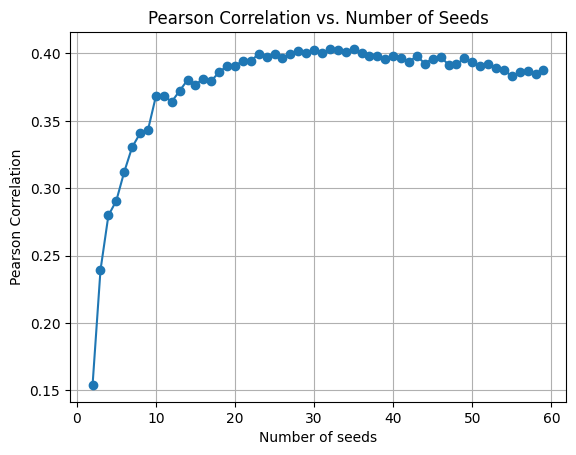

#### TESTING A VALUE: 0.5 ##########
#### TESTING B VALUE: 2 ##########
1.5
#### TESTING A VALUE: 0.5 ##########
#### TESTING B VALUE: 3 ##########
2.5
#### TESTING A VALUE: 0.5 ##########
#### TESTING B VALUE: 4 ##########
3.5
#### TESTING A VALUE: 0.5 ##########
#### TESTING B VALUE: 5 ##########
4.5
#### TESTING A VALUE: 1 ##########
#### TESTING B VALUE: 0 ##########
-1.0
#### TESTING A VALUE: 1 ##########
#### TESTING B VALUE: 1 ##########
0.0
[0.2057016129469541, 0.3851727555400952, 0.4159473699833355, 0.25484628777249496, 0.5771555774957715, 0.05424577539128905, 0.4890911813821941, 0.5183799301619567, 0.5573847819789766, 0.3559812632303211, 0.5125848352823708, 0.5191117441192281, 0.5702499979040184, 0.5534442951388135, 0.42098802213225195, 0.5664067864900357, 0.28397995211986726, 0.41495373411037106, 0.4116288147987516, 0.6922473818829475, 0.8112823857418523, 0.3940535713025155, 0.8111276072264424, 0.828271265955504, 0.6765512487028484, 1.0, 0.7340756081546734, 0.650897801208415

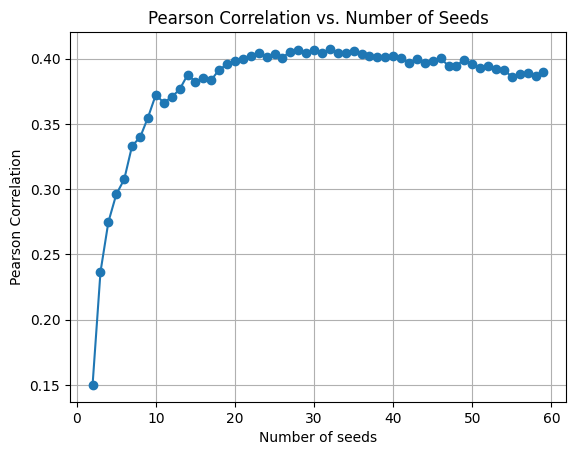

#### TESTING A VALUE: 1 ##########
#### TESTING B VALUE: 2 ##########
1.0
[1.205701612946954, 1.3851727555400952, 1.4159473699833356, 1.2548462877724949, 1.5771555774957715, 1.054245775391289, 1.489091181382194, 1.5183799301619567, 1.5573847819789766, 1.355981263230321, 1.5125848352823708, 1.5191117441192281, 1.5702499979040185, 1.5534442951388137, 1.420988022132252, 1.5664067864900357, 1.2839799521198674, 1.414953734110371, 1.4116288147987515, 1.6922473818829475, 1.8112823857418523, 1.3940535713025155, 1.8111276072264424, 1.828271265955504, 1.6765512487028484, 2.0, 1.7340756081546735, 1.6508978012084152, 1.7988395593051394, 1.76710985974609, 1.2977154388180896, 1.3861873167916534, 1.394566321606694, 1.5075875815141864, 1.4638122082589344, 1.51720004465788, 1.5932086089113677, 1.616211051194806, 1.4186091282641224, 1.616913060516578, 1.489510216336021, 1.4837870236813537, 1.4942323700260776, 1.4430941039591771, 1.4722201015958345, 1.4926391537658867, 1.1006416269784896, 1.2463325658030

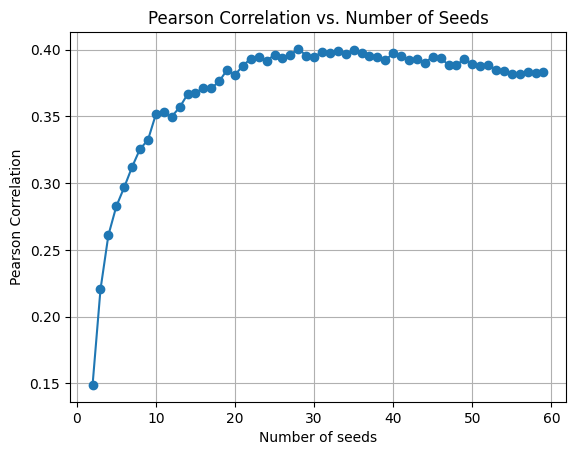

#### TESTING A VALUE: 1 ##########
#### TESTING B VALUE: 3 ##########
2.0
#### TESTING A VALUE: 1 ##########
#### TESTING B VALUE: 4 ##########
3.0
#### TESTING A VALUE: 1 ##########
#### TESTING B VALUE: 5 ##########
4.0
#### TESTING A VALUE: 2 ##########
#### TESTING B VALUE: 0 ##########
-2.0
#### TESTING A VALUE: 2 ##########
#### TESTING B VALUE: 1 ##########
-1.0
[-0.5885967741060918, -0.22965448891980955, -0.16810526003332904, -0.4903074244550101, 0.15431115499154302, -0.8915084492174219, -0.02181763723561181, 0.03675986032391343, 0.11476956395795312, -0.2880374735393578, 0.02516967056474162, 0.03822348823845623, 0.14049999580803685, 0.1068885902776271, -0.1580239557354961, 0.13281357298007146, -0.4320400957602655, -0.17009253177925787, -0.17674237040249685, 0.3844947637658951, 0.6225647714837047, -0.211892857394969, 0.6222552144528848, 0.6565425319110082, 0.353102497405697, 1.0, 0.46815121630934686, 0.30179560241683023, 0.597679118610279, 0.5342197194921798, -0.4045691223638208

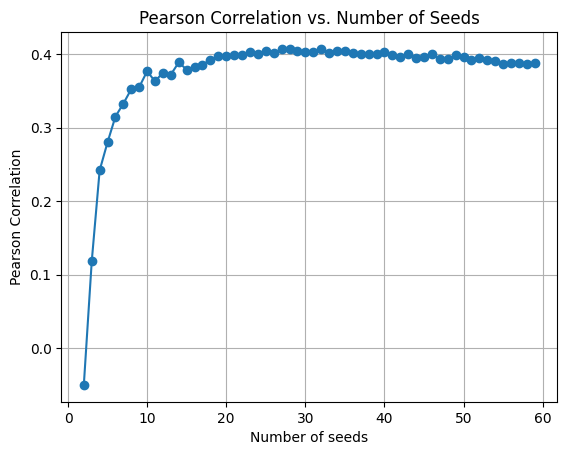

#### TESTING A VALUE: 2 ##########
#### TESTING B VALUE: 2 ##########
0.0
[0.4114032258939082, 0.7703455110801904, 0.831894739966671, 0.5096925755449899, 1.154311154991543, 0.1084915507825781, 0.9781823627643882, 1.0367598603239134, 1.1147695639579531, 0.7119625264606422, 1.0251696705647415, 1.0382234882384562, 1.1404999958080368, 1.106888590277627, 0.8419760442645039, 1.1328135729800715, 0.5679599042397345, 0.8299074682207421, 0.8232576295975031, 1.384494763765895, 1.6225647714837046, 0.788107142605031, 1.6222552144528848, 1.656542531911008, 1.3531024974056969, 2.0, 1.4681512163093469, 1.3017956024168302, 1.597679118610279, 1.5342197194921798, 0.5954308776361792, 0.772374633583307, 0.7891326432133876, 1.0151751630283727, 0.9276244165178686, 1.0344000893157599, 1.1864172178227357, 1.2324221023896118, 0.8372182565282449, 1.233826121033156, 0.979020432672042, 0.9675740473627075, 0.9884647400521553, 0.8861882079183545, 0.9444402031916692, 0.9852783075317737, 0.20128325395697888, 0.4926651

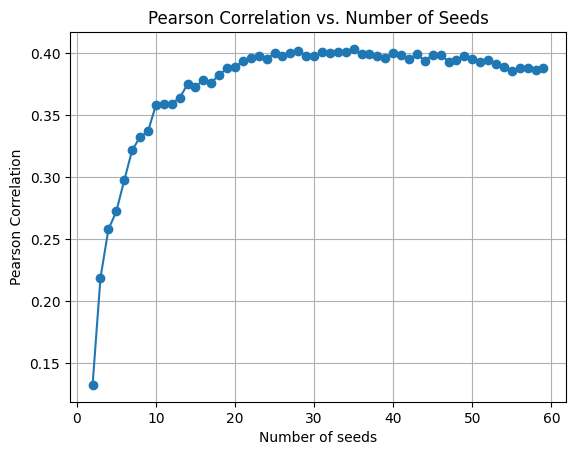

#### TESTING A VALUE: 2 ##########
#### TESTING B VALUE: 3 ##########
1.0
[1.4114032258939082, 1.7703455110801904, 1.831894739966671, 1.50969257554499, 2.154311154991543, 1.108491550782578, 1.9781823627643882, 2.0367598603239134, 2.114769563957953, 1.7119625264606422, 2.0251696705647415, 2.0382234882384562, 2.140499995808037, 2.1068885902776273, 1.841976044264504, 2.1328135729800715, 1.5679599042397345, 1.8299074682207421, 1.8232576295975031, 2.384494763765895, 2.6225647714837046, 1.788107142605031, 2.622255214452885, 2.656542531911008, 2.353102497405697, 3.0, 2.468151216309347, 2.3017956024168305, 2.597679118610279, 2.53421971949218, 1.5954308776361792, 1.772374633583307, 1.7891326432133876, 2.0151751630283727, 1.9276244165178686, 2.03440008931576, 2.1864172178227355, 2.232422102389612, 1.8372182565282449, 2.233826121033156, 1.979020432672042, 1.9675740473627075, 1.9884647400521553, 1.8861882079183545, 1.9444402031916692, 1.9852783075317737, 1.2012832539569789, 1.4926651316061426, 1.2

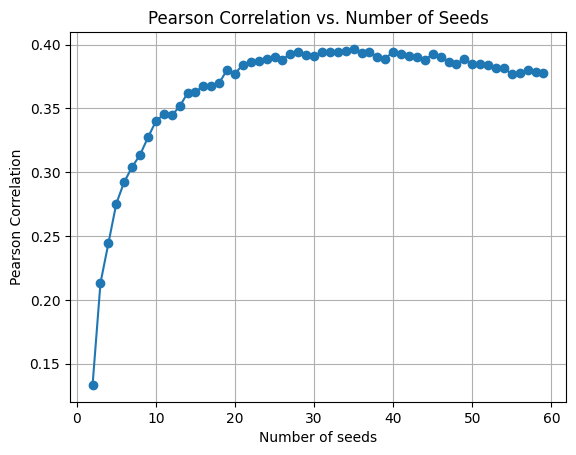

#### TESTING A VALUE: 2 ##########
#### TESTING B VALUE: 4 ##########
2.0
#### TESTING A VALUE: 2 ##########
#### TESTING B VALUE: 5 ##########
3.0
#### TESTING A VALUE: 3 ##########
#### TESTING B VALUE: 0 ##########
-3.0
#### TESTING A VALUE: 3 ##########
#### TESTING B VALUE: 1 ##########
-2.0
[-1.3828951611591376, -0.8444817333797143, -0.7521578900499937, -1.235461136682515, -0.26853326751268547, -1.8372626738261326, -0.5327264558534177, -0.44486020951412986, -0.3278456540630703, -0.9320562103090366, -0.4622454941528875, -0.44266476764231566, -0.28925000628794484, -0.33966711458355947, -0.7370359336032442, -0.3007796405298928, -1.1480601436403983, -0.7551387976688868, -0.7651135556037452, 0.07674214564884263, 0.4338471572255571, -0.8178392860924535, 0.4333828216793273, 0.48481379786651235, 0.029653746108545542, 1.0, 0.2022268244640203, -0.04730659637475476, 0.3965186779154184, 0.30132957923826975, -1.1068536835457312, -0.8414380496250393, -0.8163010351799187, -0.47723725545744067, 

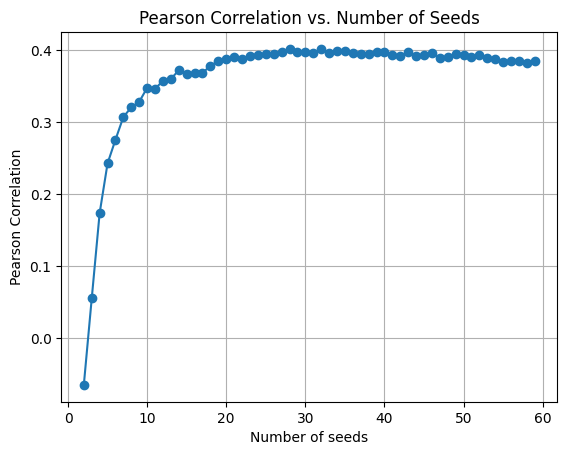

#### TESTING A VALUE: 3 ##########
#### TESTING B VALUE: 2 ##########
-1.0
[-0.3828951611591376, 0.15551826662028567, 0.24784210995000633, -0.235461136682515, 0.7314667324873145, -0.8372626738261326, 0.4672735441465823, 0.5551397904858701, 0.6721543459369297, 0.06794378969096337, 0.5377545058471125, 0.5573352323576843, 0.7107499937120552, 0.6603328854164405, 0.26296406639675585, 0.6992203594701072, -0.14806014364039832, 0.2448612023311132, 0.23488644439625483, 1.0767421456488426, 1.4338471572255571, 0.1821607139075465, 1.4333828216793272, 1.4848137978665124, 1.0296537461085455, 2.0, 1.2022268244640202, 0.9526934036252452, 1.3965186779154184, 1.3013295792382698, -0.10685368354573122, 0.15856195037496068, 0.1836989648200813, 0.5227627445425593, 0.39143662477680286, 0.55160013397364, 0.7796258267341036, 0.8486331535844176, 0.25582738479236733, 0.850739181549734, 0.46853064900806296, 0.4513610710440612, 0.4826971100782331, 0.3292823118775319, 0.41666030478750393, 0.47791746129766066, -0.69

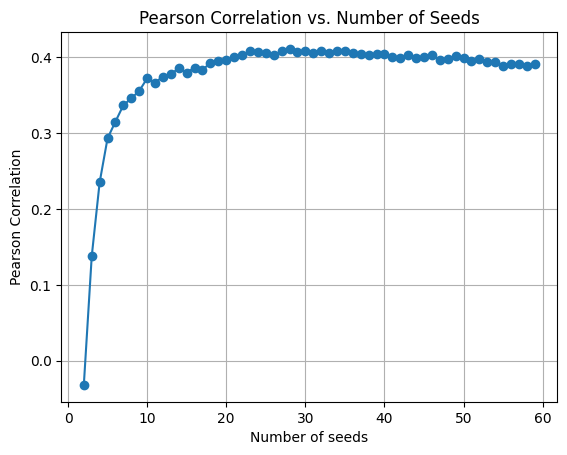

#### TESTING A VALUE: 3 ##########
#### TESTING B VALUE: 3 ##########
0.0
[0.6171048388408624, 1.1555182666202857, 1.2478421099500063, 0.764538863317485, 1.7314667324873145, 0.16273732617386738, 1.4672735441465823, 1.5551397904858701, 1.6721543459369297, 1.0679437896909634, 1.5377545058471125, 1.5573352323576843, 1.7107499937120552, 1.6603328854164405, 1.2629640663967558, 1.6992203594701072, 0.8519398563596017, 1.2448612023311132, 1.2348864443962548, 2.0767421456488426, 2.433847157225557, 1.1821607139075465, 2.433382821679327, 2.4848137978665124, 2.0296537461085453, 3.0, 2.20222682446402, 1.9526934036252452, 2.3965186779154184, 2.3013295792382698, 0.8931463164542688, 1.1585619503749607, 1.1836989648200813, 1.5227627445425593, 1.3914366247768029, 1.55160013397364, 1.7796258267341036, 1.8486331535844176, 1.2558273847923673, 1.850739181549734, 1.468530649008063, 1.4513610710440612, 1.4826971100782331, 1.3292823118775319, 1.416660304787504, 1.4779174612976607, 0.3019248809354682, 0.7389976

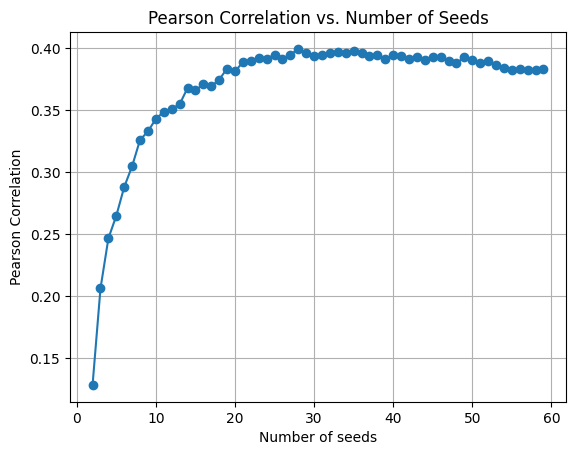

#### TESTING A VALUE: 3 ##########
#### TESTING B VALUE: 4 ##########
1.0
[1.6171048388408624, 2.1555182666202857, 2.2478421099500063, 1.764538863317485, 2.7314667324873145, 1.1627373261738674, 2.4672735441465825, 2.55513979048587, 2.6721543459369297, 2.0679437896909634, 2.5377545058471123, 2.5573352323576843, 2.710749993712055, 2.6603328854164405, 2.262964066396756, 2.6992203594701074, 1.8519398563596017, 2.244861202331113, 2.234886444396255, 3.0767421456488426, 3.433847157225557, 2.1821607139075465, 3.433382821679327, 3.4848137978665124, 3.0296537461085453, 4.0, 3.20222682446402, 2.9526934036252452, 3.3965186779154184, 3.3013295792382698, 1.8931463164542688, 2.1585619503749607, 2.1836989648200813, 2.5227627445425593, 2.391436624776803, 2.55160013397364, 2.7796258267341036, 2.8486331535844176, 2.2558273847923673, 2.8507391815497343, 2.4685306490080627, 2.451361071044061, 2.482697110078233, 2.329282311877532, 2.416660304787504, 2.4779174612976607, 1.3019248809354682, 1.7389976974092138

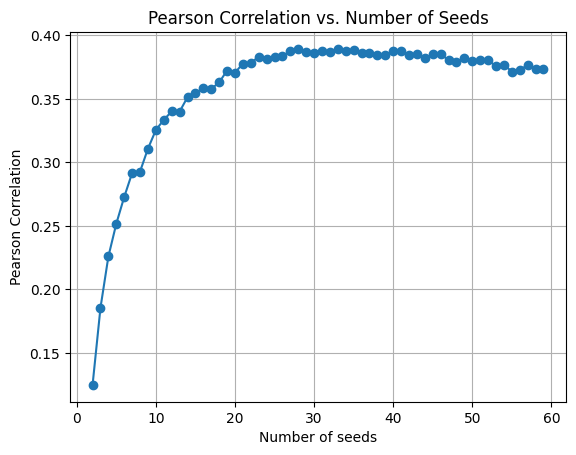

#### TESTING A VALUE: 3 ##########
#### TESTING B VALUE: 5 ##########
2.0
#### TESTING A VALUE: 4 ##########
#### TESTING B VALUE: 0 ##########
-4.0
#### TESTING A VALUE: 4 ##########
#### TESTING B VALUE: 1 ##########
-3.0
[-2.1771935482121836, -1.459308977839619, -1.336210520066658, -1.9806148489100202, -0.691377690016914, -2.783016898434844, -1.0436352744712236, -0.9264802793521731, -0.7704608720840938, -1.5760749470787156, -0.9496606588705168, -0.9235530235230875, -0.7190000083839263, -0.7862228194447458, -1.3160479114709922, -0.7343728540398571, -1.864080191520531, -1.3401850635585157, -1.3534847408049937, -0.23101047246820983, 0.2451295429674094, -1.423785714789938, 0.24451042890576968, 0.3130850638220164, -0.293795005188606, 1.0, -0.06369756738130627, -0.39640879516633953, 0.1953582372205579, 0.06843943898435967, -1.8091382447276416, -1.455250732833386, -1.4217347135732248, -0.9696496739432543, -1.1447511669642627, -0.93119982136848, -0.6271655643545286, -0.5351557952207764, -1.

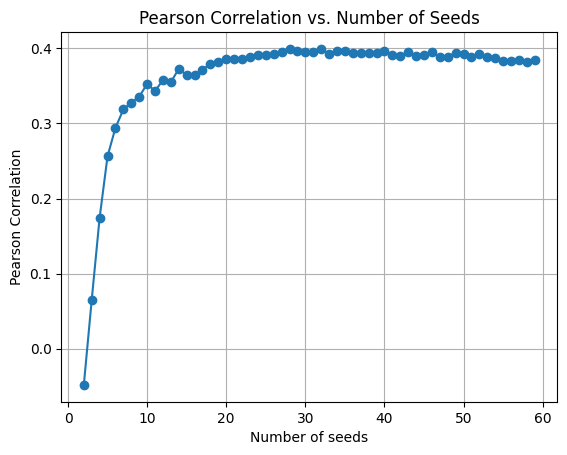

#### TESTING A VALUE: 4 ##########
#### TESTING B VALUE: 2 ##########
-2.0
[-1.1771935482121836, -0.4593089778396191, -0.3362105200666581, -0.9806148489100202, 0.30862230998308604, -1.7830168984348438, -0.04363527447122362, 0.07351972064782686, 0.22953912791590625, -0.5760749470787156, 0.05033934112948324, 0.07644697647691245, 0.2809999916160737, 0.2137771805552542, -0.3160479114709922, 0.2656271459601429, -0.864080191520531, -0.34018506355851574, -0.3534847408049937, 0.7689895275317902, 1.2451295429674094, -0.423785714789938, 1.2445104289057696, 1.3130850638220164, 0.706204994811394, 2.0, 0.9363024326186937, 0.6035912048336605, 1.195358237220558, 1.0684394389843597, -0.8091382447276416, -0.4552507328333859, -0.4217347135732248, 0.030350326056745702, -0.1447511669642627, 0.06880017863151999, 0.37283443564547136, 0.4648442047792236, -0.3255634869435102, 0.46765224206631206, -0.04195913465591605, -0.06485190527458506, -0.023070519895689312, -0.22762358416329098, -0.11111959361666157, -0.

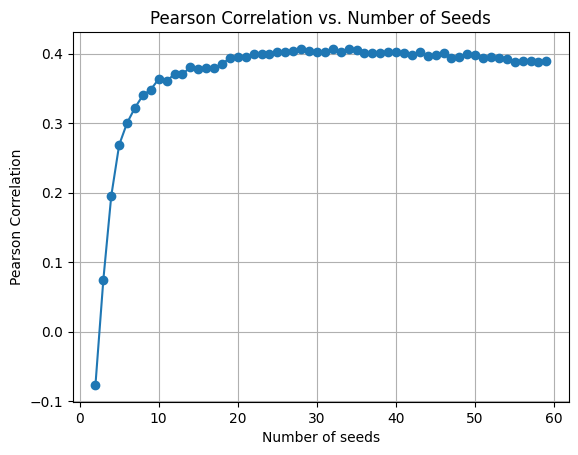

#### TESTING A VALUE: 4 ##########
#### TESTING B VALUE: 3 ##########
-1.0
[-0.17719354821218358, 0.5406910221603809, 0.6637894799333419, 0.019385151089979846, 1.308622309983086, -0.7830168984348438, 0.9563647255287764, 1.0735197206478269, 1.2295391279159062, 0.42392505292128435, 1.0503393411294832, 1.0764469764769125, 1.2809999916160737, 1.2137771805552542, 0.6839520885290078, 1.265627145960143, 0.13591980847946905, 0.6598149364414843, 0.6465152591950063, 1.7689895275317902, 2.245129542967409, 0.576214285210062, 2.2445104289057696, 2.313085063822016, 1.706204994811394, 3.0, 1.9363024326186937, 1.6035912048336605, 2.195358237220558, 2.0684394389843597, 0.19086175527235838, 0.5447492671666141, 0.5782652864267752, 1.0303503260567457, 0.8552488330357373, 1.06880017863152, 1.3728344356454714, 1.4648442047792236, 0.6744365130564898, 1.467652242066312, 0.958040865344084, 0.9351480947254149, 0.9769294801043107, 0.772376415836709, 0.8888804063833384, 0.9705566150635474, -0.5974334920860422, -0

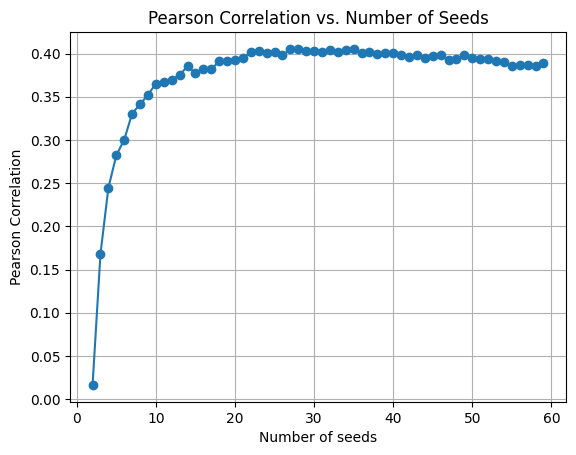

#### TESTING A VALUE: 4 ##########
#### TESTING B VALUE: 4 ##########
0.0
[0.8228064517878164, 1.540691022160381, 1.663789479933342, 1.0193851510899798, 2.308622309983086, 0.2169831015651562, 1.9563647255287764, 2.073519720647827, 2.2295391279159062, 1.4239250529212844, 2.050339341129483, 2.0764469764769125, 2.2809999916160737, 2.213777180555254, 1.6839520885290078, 2.265627145960143, 1.135919808479469, 1.6598149364414843, 1.6465152591950063, 2.76898952753179, 3.245129542967409, 1.576214285210062, 3.2445104289057696, 3.313085063822016, 2.7062049948113938, 4.0, 2.9363024326186937, 2.6035912048336605, 3.195358237220558, 3.0684394389843597, 1.1908617552723584, 1.544749267166614, 1.5782652864267752, 2.0303503260567455, 1.8552488330357373, 2.0688001786315198, 2.3728344356454714, 2.4648442047792236, 1.6744365130564898, 2.467652242066312, 1.958040865344084, 1.935148094725415, 1.9769294801043107, 1.772376415836709, 1.8888804063833384, 1.9705566150635474, 0.40256650791395776, 0.9853302632122851

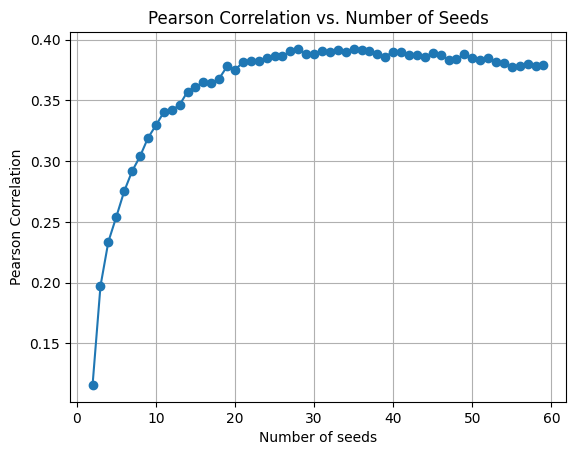

#### TESTING A VALUE: 4 ##########
#### TESTING B VALUE: 5 ##########
1.0
[1.8228064517878164, 2.540691022160381, 2.663789479933342, 2.01938515108998, 3.308622309983086, 1.2169831015651562, 2.9563647255287764, 3.073519720647827, 3.2295391279159062, 2.4239250529212844, 3.050339341129483, 3.0764469764769125, 3.2809999916160737, 3.213777180555254, 2.683952088529008, 3.265627145960143, 2.135919808479469, 2.6598149364414843, 2.6465152591950063, 3.76898952753179, 4.245129542967409, 2.576214285210062, 4.24451042890577, 4.313085063822016, 3.7062049948113938, 5.0, 3.9363024326186937, 3.6035912048336605, 4.195358237220558, 4.06843943898436, 2.1908617552723584, 2.544749267166614, 2.578265286426775, 3.0303503260567455, 2.8552488330357373, 3.0688001786315198, 3.3728344356454714, 3.4648442047792236, 2.6744365130564898, 3.467652242066312, 2.958040865344084, 2.935148094725415, 2.9769294801043107, 2.772376415836709, 2.8888804063833384, 2.9705566150635474, 1.4025665079139578, 1.9853302632122851, 1.47205

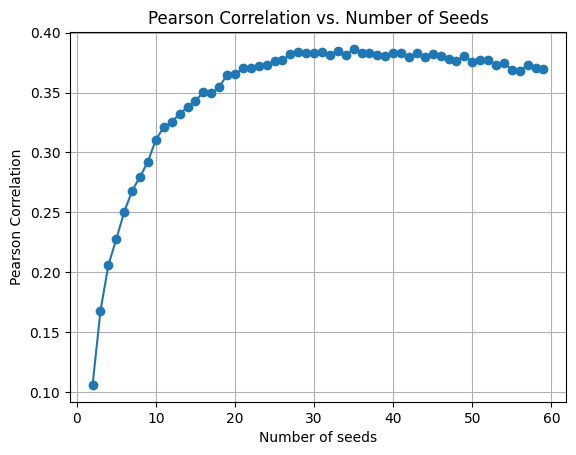

#### TESTING A VALUE: 5 ##########
#### TESTING B VALUE: 0 ##########
-5.0
#### TESTING A VALUE: 5 ##########
#### TESTING B VALUE: 1 ##########
-4.0
[-2.9714919352652296, -2.074136222299524, -1.9202631500833225, -2.7257685611375253, -1.1142221125211424, -3.728771123043555, -1.5545440930890297, -1.4081003491902164, -1.2130760901051172, -2.2200936838483947, -1.4370758235881458, -1.4044412794038594, -1.1487500104799078, -1.2327785243059322, -1.8950598893387403, -1.1679660675498216, -2.5801002394006636, -1.9252313294481445, -1.9418559260062422, -0.5387630905852623, 0.056411928709261705, -2.0297321434874225, 0.055638036132212076, 0.14135632977752044, -0.6172437564857576, 1.0, -0.32962195922663273, -0.7455109939579243, -0.005802203474302603, -0.16445070126955041, -2.511422805909552, -2.0690634160417325, -2.027168391966531, -1.462062092429068, -1.6809389587053283, -1.4139997767105998, -1.033956955443161, -0.9189447440259704, -1.9069543586793878, -0.9154346974171099, -1.5524489183198948, -1.5

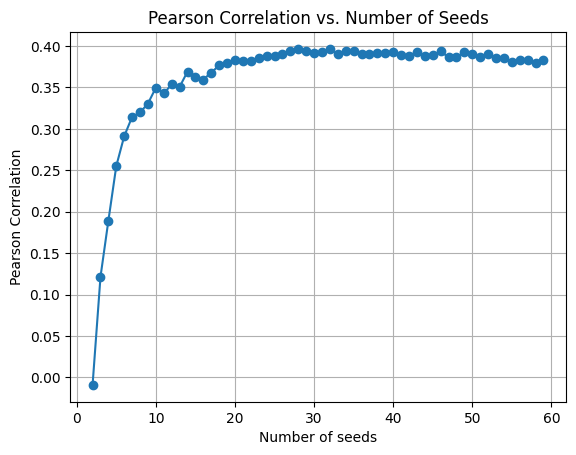

#### TESTING A VALUE: 5 ##########
#### TESTING B VALUE: 2 ##########
-3.0
[-1.9714919352652296, -1.0741362222995239, -0.9202631500833225, -1.7257685611375253, -0.11422211252114245, -2.728771123043555, -0.5545440930890297, -0.4081003491902164, -0.2130760901051172, -1.2200936838483947, -0.4370758235881458, -0.40444127940385943, -0.14875001047990777, -0.23277852430593216, -0.8950598893387403, -0.16796606754982157, -1.5801002394006636, -0.9252313294481445, -0.9418559260062422, 0.4612369094147377, 1.0564119287092617, -1.0297321434874225, 1.055638036132212, 1.1413563297775204, 0.3827562435142424, 2.0, 0.6703780407733673, 0.2544890060420757, 0.9941977965256974, 0.8355492987304496, -1.511422805909552, -1.0690634160417325, -1.0271683919665309, -0.4620620924290679, -0.6809389587053283, -0.41399977671059984, -0.03395695544316091, 0.08105525597402963, -0.9069543586793878, 0.08456530258289008, -0.5524489183198948, -0.5810648815932313, -0.5288381498696118, -0.7845294802041138, -0.6388994920208271, 

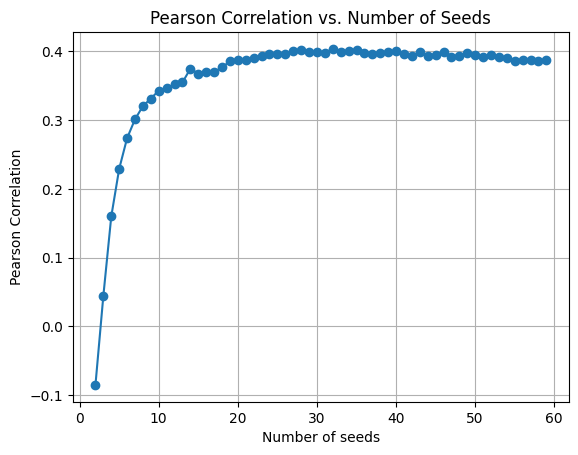

#### TESTING A VALUE: 5 ##########
#### TESTING B VALUE: 3 ##########
-2.0
[-0.9714919352652296, -0.07413622229952388, 0.07973684991667751, -0.7257685611375253, 0.8857778874788576, -1.728771123043555, 0.44545590691097026, 0.5918996508097836, 0.7869239098948828, -0.22009368384839467, 0.5629241764118542, 0.5955587205961406, 0.8512499895200922, 0.7672214756940678, 0.10494011066125974, 0.8320339324501784, -0.5801002394006636, 0.07476867055185554, 0.05814407399375776, 1.4612369094147377, 2.0564119287092617, -0.02973214348742248, 2.055638036132212, 2.1413563297775204, 1.3827562435142424, 3.0, 1.6703780407733673, 1.2544890060420757, 1.9941977965256974, 1.8355492987304496, -0.511422805909552, -0.0690634160417325, -0.02716839196653087, 0.5379379075709321, 0.3190610412946717, 0.5860002232894002, 0.9660430445568391, 1.0810552559740296, 0.09304564132061222, 1.08456530258289, 0.44755108168010516, 0.41893511840676867, 0.47116185013038825, 0.21547051979588616, 0.3611005079791729, 0.46319576882943414,

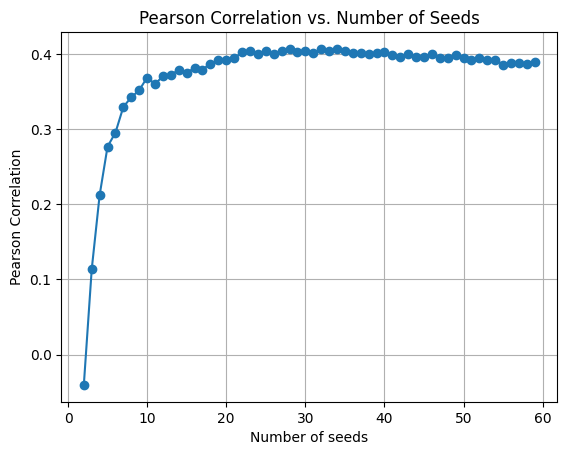

#### TESTING A VALUE: 5 ##########
#### TESTING B VALUE: 4 ##########
-1.0
[0.02850806473477041, 0.9258637777004761, 1.0797368499166775, 0.2742314388624747, 1.8857778874788576, -0.728771123043555, 1.4454559069109703, 1.5918996508097836, 1.7869239098948828, 0.7799063161516053, 1.5629241764118542, 1.5955587205961406, 1.8512499895200922, 1.7672214756940678, 1.1049401106612597, 1.8320339324501784, 0.4198997605993364, 1.0747686705518555, 1.0581440739937578, 2.4612369094147377, 3.0564119287092617, 0.9702678565125775, 3.055638036132212, 3.1413563297775204, 2.382756243514242, 4.0, 2.6703780407733673, 2.2544890060420757, 2.9941977965256976, 2.8355492987304496, 0.488577194090448, 0.9309365839582675, 0.9728316080334691, 1.537937907570932, 1.3190610412946717, 1.5860002232894002, 1.966043044556839, 2.0810552559740296, 1.0930456413206122, 2.08456530258289, 1.4475510816801052, 1.4189351184067687, 1.4711618501303882, 1.2154705197958862, 1.361100507979173, 1.4631957688294341, -0.4967918651075527, 0.231

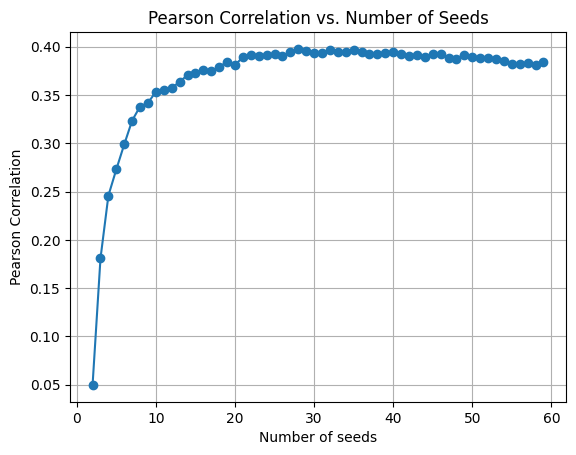

#### TESTING A VALUE: 5 ##########
#### TESTING B VALUE: 5 ##########
0.0
[1.0285080647347704, 1.9258637777004761, 2.0797368499166775, 1.2742314388624747, 2.8857778874788576, 0.27122887695644504, 2.4454559069109703, 2.5918996508097836, 2.786923909894883, 1.7799063161516053, 2.562924176411854, 2.5955587205961406, 2.8512499895200922, 2.767221475694068, 2.1049401106612597, 2.8320339324501784, 1.4198997605993364, 2.0747686705518555, 2.0581440739937578, 3.4612369094147377, 4.056411928709261, 1.9702678565125775, 4.055638036132212, 4.141356329777521, 3.382756243514242, 5.0, 3.6703780407733673, 3.2544890060420757, 3.9941977965256976, 3.8355492987304496, 1.488577194090448, 1.9309365839582675, 1.9728316080334691, 2.537937907570932, 2.3190610412946717, 2.5860002232894, 2.966043044556839, 3.0810552559740296, 2.093045641320612, 3.08456530258289, 2.447551081680105, 2.4189351184067687, 2.4711618501303882, 2.215470519795886, 2.361100507979173, 2.463195768829434, 0.5032081348924473, 1.2316628290153564,

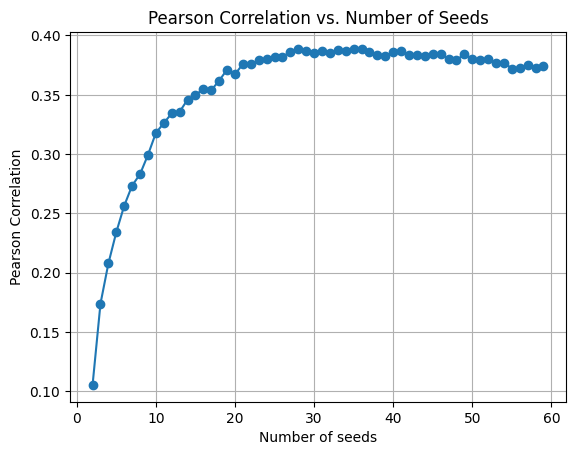

#### TESTING A VALUE: 6 ##########
#### TESTING B VALUE: 0 ##########
-6.0
#### TESTING A VALUE: 6 ##########
#### TESTING B VALUE: 1 ##########
-5.0
[-3.765790322318275, -2.6889634667594287, -2.5043157800999873, -3.47092227336503, -1.537066535025371, -4.674525347652265, -2.0654529117068354, -1.8897204190282597, -1.6556913081261406, -2.8641124206180733, -1.924490988305775, -1.8853295352846313, -1.5785000125758897, -1.679334229167119, -2.4740718672064883, -1.6015592810597856, -3.2961202872807966, -2.5102775953377736, -2.5302271112074903, -0.8465157087023147, -0.13230568554888578, -2.635678572184907, -0.13323435664134542, -0.030372404266975295, -0.9406925077829089, 1.0, -0.5955463510719594, -1.0946131927495095, -0.2069626441691632, -0.3973408415234605, -3.2137073670914624, -2.6828760992500786, -2.6326020703598374, -1.9544745109148813, -2.2171267504463943, -1.89679973205272, -1.4407483465317927, -1.3027336928311648, -2.4883452304152653, -1.298521636900532, -2.062938701983874, -2.097277857

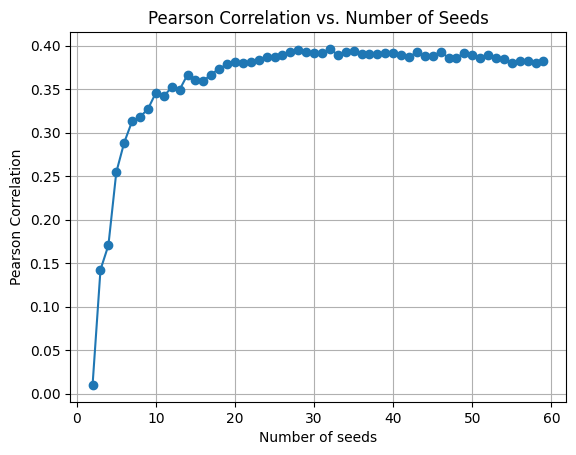

#### TESTING A VALUE: 6 ##########
#### TESTING B VALUE: 2 ##########
-4.0
[-2.765790322318275, -1.6889634667594287, -1.5043157800999873, -2.47092227336503, -0.5370665350253709, -3.6745253476522652, -1.0654529117068354, -0.8897204190282597, -0.6556913081261406, -1.8641124206180733, -0.924490988305775, -0.8853295352846313, -0.5785000125758897, -0.6793342291671189, -1.4740718672064883, -0.6015592810597856, -2.2961202872807966, -1.5102775953377736, -1.5302271112074903, 0.15348429129768526, 0.8676943144511142, -1.635678572184907, 0.8667656433586546, 0.9696275957330247, 0.059307492217091085, 2.0, 0.4044536489280406, -0.09461319274950952, 0.7930373558308368, 0.6026591584765395, -2.2137073670914624, -1.6828760992500786, -1.6326020703598374, -0.9544745109148813, -1.2171267504463943, -0.8967997320527199, -0.44074834653179273, -0.3027336928311648, -1.4883452304152653, -0.2985216369005319, -1.062938701983874, -1.0972778579118776, -1.0346057798435337, -1.3414353762449363, -1.1666793904249921, -1.0

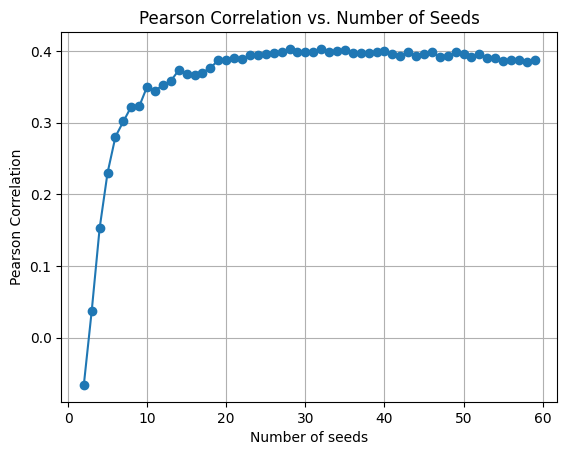

#### TESTING A VALUE: 6 ##########
#### TESTING B VALUE: 3 ##########
-3.0
[-1.7657903223182752, -0.6889634667594287, -0.5043157800999873, -1.47092227336503, 0.46293346497462906, -2.6745253476522652, -0.06545291170683543, 0.11027958097174029, 0.3443086918738594, -0.8641124206180733, 0.07550901169422497, 0.11467046471536868, 0.4214999874241103, 0.32066577083288106, -0.4740718672064883, 0.3984407189402144, -1.2961202872807966, -0.5102775953377736, -0.5302271112074903, 1.1534842912976853, 1.8676943144511142, -0.635678572184907, 1.8667656433586546, 1.9696275957330247, 1.059307492217091, 3.0, 1.4044536489280406, 0.9053868072504905, 1.7930373558308368, 1.6026591584765395, -1.2137073670914624, -0.6828760992500786, -0.6326020703598374, 0.045525489085118664, -0.2171267504463943, 0.1032002679472801, 0.5592516534682073, 0.6972663071688352, -0.48834523041526534, 0.7014783630994681, -0.06293870198387408, -0.0972778579118776, -0.034605779843533746, -0.34143537624493625, -0.16667939042499214, -0.0441

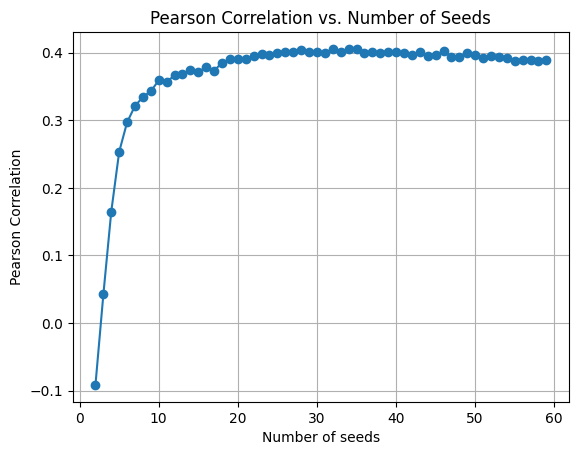

#### TESTING A VALUE: 6 ##########
#### TESTING B VALUE: 4 ##########
-2.0
[-0.7657903223182752, 0.31103653324057134, 0.49568421990001266, -0.47092227336503, 1.462933464974629, -1.6745253476522652, 0.9345470882931646, 1.1102795809717403, 1.3443086918738594, 0.13588757938192675, 1.075509011694225, 1.1146704647153687, 1.4214999874241103, 1.320665770832881, 0.5259281327935117, 1.3984407189402144, -0.29612028728079665, 0.4897224046622264, 0.46977288879250967, 2.1534842912976853, 2.8676943144511142, 0.364321427815093, 2.8667656433586544, 2.9696275957330247, 2.059307492217091, 4.0, 2.4044536489280404, 1.9053868072504905, 2.793037355830837, 2.6026591584765395, -0.21370736709146243, 0.31712390074992136, 0.3673979296401626, 1.0455254890851187, 0.7828732495536057, 1.10320026794728, 1.5592516534682073, 1.6972663071688352, 0.5116547695847347, 1.701478363099468, 0.9370612980161259, 0.9027221420881224, 0.9653942201564663, 0.6585646237550637, 0.8333206095750079, 0.9558349225953213, -1.396150238129063

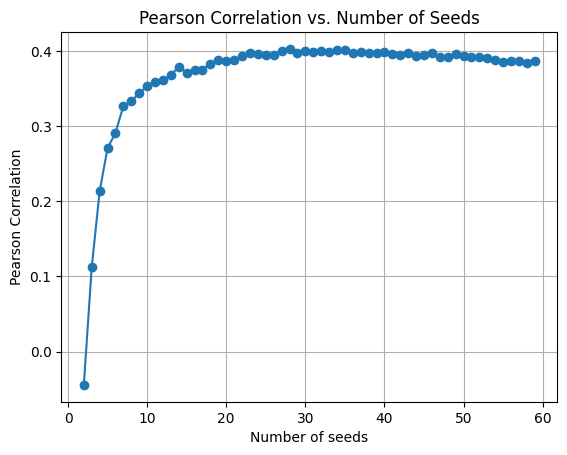

#### TESTING A VALUE: 6 ##########
#### TESTING B VALUE: 5 ##########
-1.0
[0.23420967768172485, 1.3110365332405713, 1.4956842199000127, 0.52907772663497, 2.462933464974629, -0.6745253476522652, 1.9345470882931646, 2.1102795809717403, 2.3443086918738594, 1.1358875793819267, 2.075509011694225, 2.1146704647153687, 2.4214999874241103, 2.320665770832881, 1.5259281327935117, 2.3984407189402144, 0.7038797127192034, 1.4897224046622264, 1.4697728887925097, 3.1534842912976853, 3.8676943144511142, 1.364321427815093, 3.8667656433586544, 3.9696275957330247, 3.059307492217091, 5.0, 3.4044536489280404, 2.9053868072504905, 3.793037355830837, 3.6026591584765395, 0.7862926329085376, 1.3171239007499214, 1.3673979296401626, 2.0455254890851187, 1.7828732495536057, 2.10320026794728, 2.5592516534682073, 2.697266307168835, 1.5116547695847347, 2.701478363099468, 1.937061298016126, 1.9027221420881224, 1.9653942201564663, 1.6585646237550637, 1.8333206095750079, 1.9558349225953213, -0.3961502381290636, 0.4779953

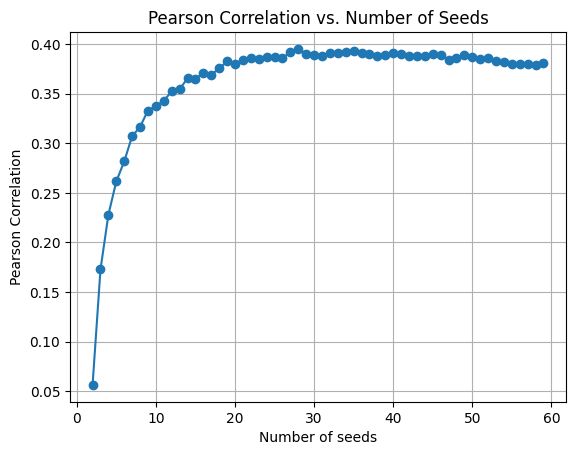

#### TESTING A VALUE: 7 ##########
#### TESTING B VALUE: 0 ##########
-7.0
#### TESTING A VALUE: 7 ##########
#### TESTING B VALUE: 1 ##########
-6.0
[-4.560088709371321, -3.3037907112193334, -3.0883684101166518, -4.216075985592536, -1.9599109575295994, -5.620279572260976, -2.576361730324641, -2.371340488866303, -2.098306526147164, -3.5081311573877523, -2.4119061530234043, -2.366217791165403, -2.008250014671871, -2.1258899340283053, -3.0530838450742364, -2.0351524945697497, -4.012140335160929, -3.0953238612274028, -3.118598296408739, -1.1542683268193672, -0.3210232998070335, -3.241625000882392, -0.322106749414903, -0.20210113831147125, -1.2641412590800605, 1.0, -0.8614707429172861, -1.4437153915410943, -0.4081230848640236, -0.6302309817773706, -3.915991928273373, -3.2966887824584257, -3.238035748753143, -2.446886929400695, -2.75331454218746, -2.37959968739484, -1.847539737620425, -1.6865226416363588, -3.0697361021511433, -1.6816085763839537, -2.5734284856478533, -2.613490834230524, -2.

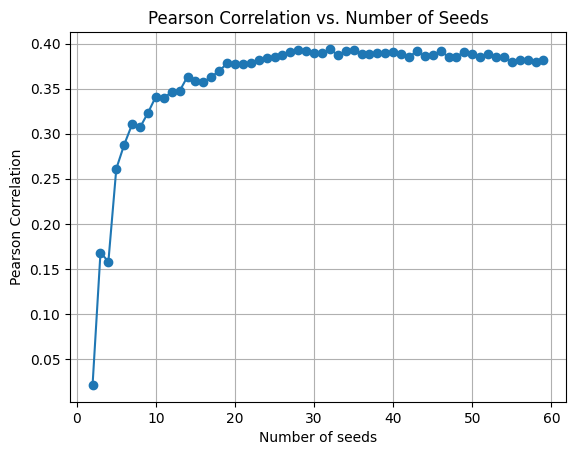

#### TESTING A VALUE: 7 ##########
#### TESTING B VALUE: 2 ##########
-5.0
[-3.560088709371321, -2.3037907112193334, -2.0883684101166518, -3.2160759855925356, -0.9599109575295994, -4.620279572260976, -1.576361730324641, -1.371340488866303, -1.098306526147164, -2.5081311573877523, -1.4119061530234043, -1.3662177911654032, -1.0082500146718711, -1.1258899340283053, -2.0530838450742364, -1.0351524945697497, -3.012140335160929, -2.0953238612274028, -2.118598296408739, -0.1542683268193672, 0.6789767001929665, -2.241625000882392, 0.677893250585097, 0.7978988616885287, -0.2641412590800605, 2.0, 0.1385292570827139, -0.4437153915410943, 0.5918769151359764, 0.3697690182226294, -2.915991928273373, -2.2966887824584257, -2.238035748753143, -1.4468869294006952, -1.7533145421874599, -1.37959968739484, -0.847539737620425, -0.6865226416363588, -2.0697361021511433, -0.6816085763839537, -1.5734284856478533, -1.6134908342305239, -1.5403734098174562, -1.898341272285759, -1.6944592888291576, -1.5515259236387

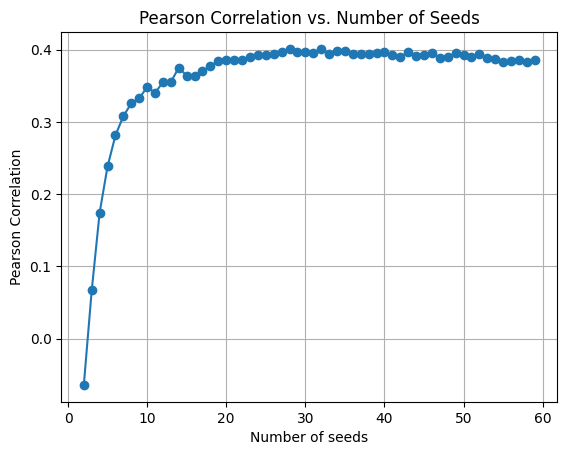

#### TESTING A VALUE: 7 ##########
#### TESTING B VALUE: 3 ##########
-4.0
[-2.560088709371321, -1.3037907112193334, -1.0883684101166518, -2.2160759855925356, 0.04008904247040057, -3.6202795722609764, -0.5763617303246411, -0.371340488866303, -0.09830652614716406, -1.5081311573877523, -0.4119061530234043, -0.3662177911654032, -0.008250014671871142, -0.12588993402830528, -1.0530838450742364, -0.03515249456974967, -2.012140335160929, -1.0953238612274028, -1.1185982964087389, 0.8457316731806328, 1.6789767001929665, -1.241625000882392, 1.677893250585097, 1.7978988616885287, 0.7358587409199395, 3.0, 1.138529257082714, 0.5562846084589057, 1.5918769151359764, 1.3697690182226294, -1.9159919282733728, -1.2966887824584257, -1.238035748753143, -0.4468869294006952, -0.7533145421874599, -0.37959968739483996, 0.152460262379575, 0.3134773583636412, -1.0697361021511433, 0.31839142361604633, -0.5734284856478533, -0.6134908342305239, -0.5403734098174562, -0.8983412722857591, -0.6944592888291576, -0.55152

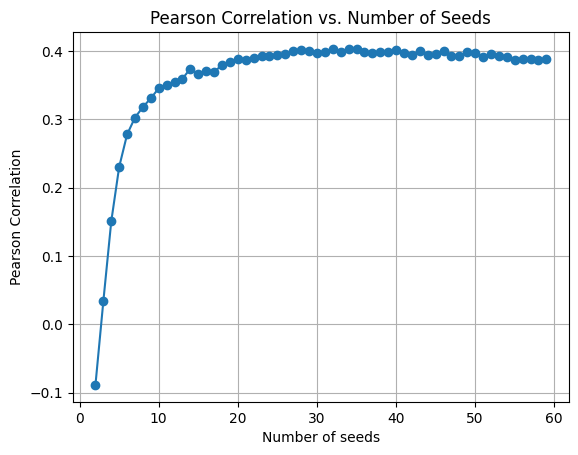

#### TESTING A VALUE: 7 ##########
#### TESTING B VALUE: 4 ##########
-3.0
[-1.5600887093713212, -0.30379071121933343, -0.08836841011665175, -1.2160759855925356, 1.0400890424704006, -2.6202795722609764, 0.4236382696753589, 0.628659511133697, 0.9016934738528359, -0.5081311573877523, 0.5880938469765957, 0.6337822088345968, 0.9917499853281289, 0.8741100659716947, -0.05308384507423636, 0.9648475054302503, -1.0121403351609288, -0.09532386122740277, -0.11859829640873887, 1.8457316731806328, 2.6789767001929663, -0.24162500088239192, 2.6778932505850968, 2.7978988616885285, 1.7358587409199395, 4.0, 2.138529257082714, 1.5562846084589057, 2.5918769151359764, 2.3697690182226294, -0.9159919282733728, -0.29668878245842567, -0.23803574875314304, 0.5531130705993048, 0.24668545781254014, 0.62040031260516, 1.152460262379575, 1.3134773583636412, -0.06973610215114334, 1.3183914236160463, 0.4265715143521467, 0.38650916576947614, 0.4596265901825438, 0.10165872771424089, 0.30554071117084236, 0.44847407636120

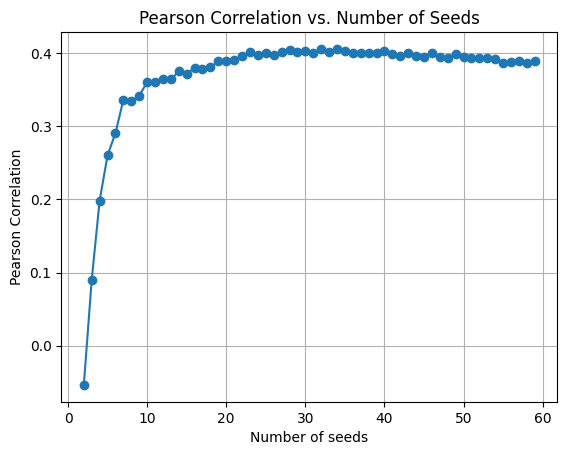

#### TESTING A VALUE: 7 ##########
#### TESTING B VALUE: 5 ##########
-2.0
[-0.5600887093713212, 0.6962092887806666, 0.9116315898833482, -0.2160759855925356, 2.0400890424704006, -1.6202795722609764, 1.423638269675359, 1.628659511133697, 1.901693473852836, 0.4918688426122477, 1.5880938469765957, 1.6337822088345968, 1.9917499853281289, 1.8741100659716947, 0.9469161549257636, 1.9648475054302503, -0.012140335160928828, 0.9046761387725972, 0.8814017035912611, 2.845731673180633, 3.6789767001929663, 0.7583749991176081, 3.6778932505850968, 3.7978988616885285, 2.7358587409199395, 5.0, 3.138529257082714, 2.5562846084589057, 3.5918769151359764, 3.3697690182226294, 0.08400807172662716, 0.7033112175415743, 0.761964251246857, 1.5531130705993048, 1.2466854578125401, 1.62040031260516, 2.152460262379575, 2.313477358363641, 0.9302638978488567, 2.3183914236160463, 1.4265715143521467, 1.3865091657694761, 1.4596265901825438, 1.101658727714241, 1.3055407111708424, 1.448474076361208, -1.2955086111505736, -0.

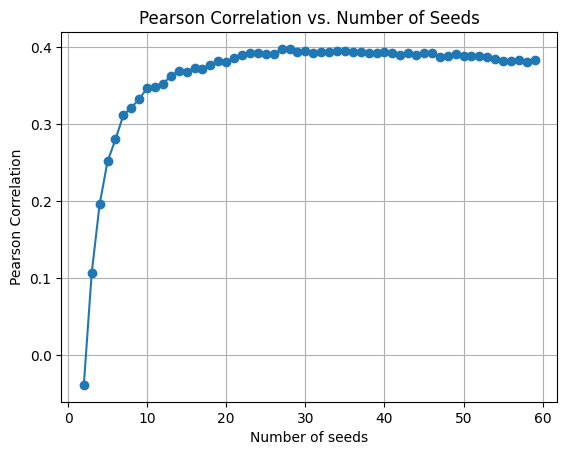

#### TESTING A VALUE: 8 ##########
#### TESTING B VALUE: 0 ##########
-8.0
#### TESTING A VALUE: 8 ##########
#### TESTING B VALUE: 1 ##########
-7.0
[-5.354387096424367, -3.918617955679238, -3.672421040133316, -4.96122969782004, -2.382755380033828, -6.566033796869688, -3.0872705489424472, -2.8529605587043463, -2.5409217441681875, -4.152149894157431, -2.8993213177410335, -2.847106047046175, -2.4380000167678526, -2.5724456388894916, -3.6320958229419844, -2.468745708079714, -4.728160383041062, -3.6803701271170315, -3.7069694816099874, -1.4620209449364197, -0.5097409140651812, -3.847571429579876, -0.5109791421884606, -0.3738298723559672, -1.587590010377212, 1.0, -1.1273951347626125, -1.792817590332679, -0.6092835255588842, -0.8631211220312807, -4.618276489455283, -3.910501465666772, -3.8434694271464496, -2.9392993478865086, -3.2895023339285254, -2.86239964273696, -2.2543311287090573, -2.0703115904415528, -3.6511269738870205, -2.064695515867376, -3.083918269311832, -3.12970381054917, -3.04

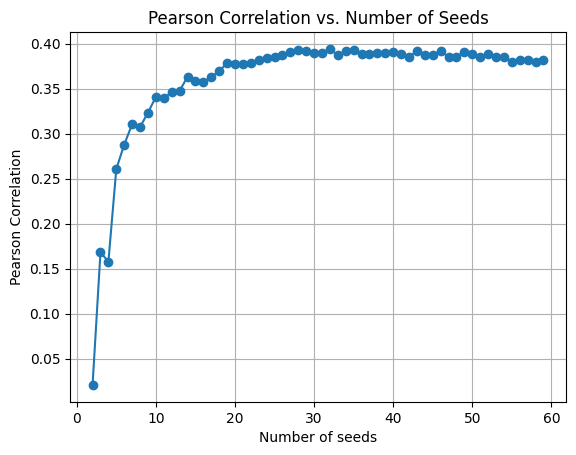

#### TESTING A VALUE: 8 ##########
#### TESTING B VALUE: 2 ##########
-6.0
[-4.354387096424367, -2.918617955679238, -2.672421040133316, -3.9612296978200403, -1.382755380033828, -5.566033796869688, -2.0872705489424472, -1.8529605587043463, -1.5409217441681875, -3.1521498941574313, -1.8993213177410335, -1.847106047046175, -1.4380000167678526, -1.5724456388894916, -2.6320958229419844, -1.4687457080797142, -3.728160383041062, -2.6803701271170315, -2.7069694816099874, -0.46202094493641965, 0.4902590859348188, -2.847571429579876, 0.48902085781153937, 0.6261701276440328, -0.587590010377212, 2.0, -0.12739513476261255, -0.7928175903326791, 0.3907164744411158, 0.13687887796871934, -3.6182764894552832, -2.910501465666772, -2.8434694271464496, -1.9392993478865086, -2.2895023339285254, -1.86239964273696, -1.2543311287090573, -1.0703115904415528, -2.6511269738870205, -1.0646955158673759, -2.083918269311832, -2.12970381054917, -2.0461410397913786, -2.455247168326582, -2.222239187233323, -2.0588867698

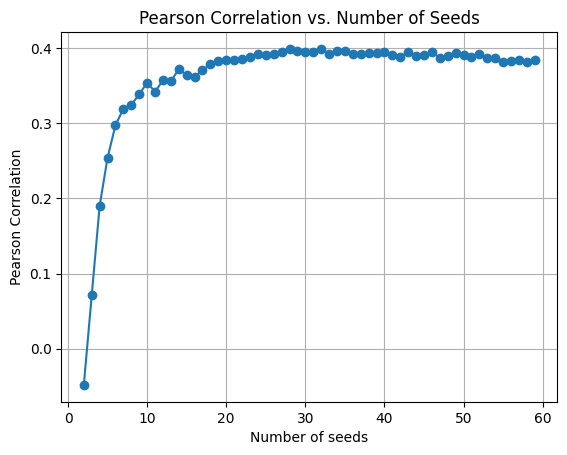

#### TESTING A VALUE: 8 ##########
#### TESTING B VALUE: 3 ##########
-5.0
[-3.354387096424367, -1.9186179556792382, -1.6724210401333162, -2.9612296978200403, -0.3827553800338279, -4.566033796869688, -1.0872705489424472, -0.8529605587043463, -0.5409217441681875, -2.1521498941574313, -0.8993213177410335, -0.8471060470461751, -0.4380000167678526, -0.5724456388894916, -1.6320958229419844, -0.46874570807971416, -2.728160383041062, -1.6803701271170315, -1.7069694816099874, 0.5379790550635803, 1.4902590859348188, -1.847571429579876, 1.4890208578115394, 1.6261701276440328, 0.41240998962278796, 3.0, 0.8726048652373875, 0.20718240966732093, 1.3907164744411158, 1.1368788779687193, -2.6182764894552832, -1.9105014656667718, -1.8434694271464496, -0.9392993478865086, -1.2895023339285254, -0.86239964273696, -0.2543311287090573, -0.07031159044155277, -1.6511269738870205, -0.06469551586737587, -1.083918269311832, -1.1297038105491701, -1.0461410397913786, -1.455247168326582, -1.2222391872333231, -1.0588

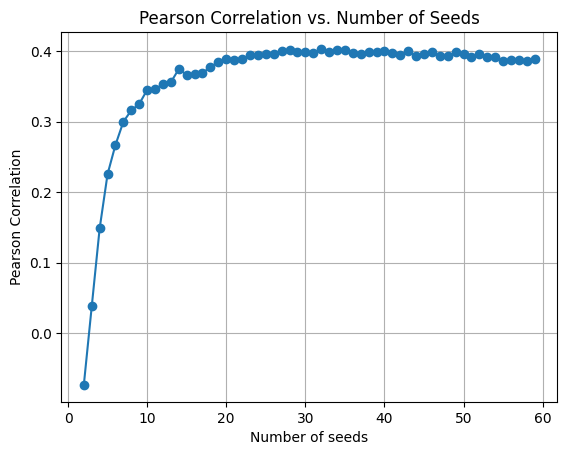

#### TESTING A VALUE: 8 ##########
#### TESTING B VALUE: 4 ##########
-4.0
[-2.354387096424367, -0.9186179556792382, -0.6724210401333162, -1.9612296978200403, 0.6172446199661721, -3.5660337968696876, -0.08727054894244723, 0.14703944129565372, 0.4590782558318125, -1.1521498941574313, 0.10067868225896648, 0.1528939529538249, 0.5619999832321474, 0.4275543611105084, -0.6320958229419844, 0.5312542919202858, -1.728160383041062, -0.6803701271170315, -0.7069694816099874, 1.5379790550635803, 2.490259085934819, -0.847571429579876, 2.489020857811539, 2.626170127644033, 1.412409989622788, 4.0, 1.8726048652373875, 1.207182409667321, 2.390716474441116, 2.1368788779687193, -1.6182764894552832, -0.9105014656667718, -0.8434694271464496, 0.060700652113491405, -0.2895023339285254, 0.13760035726303999, 0.7456688712909427, 0.9296884095584472, -0.6511269738870205, 0.9353044841326241, -0.0839182693118321, -0.12970381054917013, -0.046141039791378624, -0.45524716832658196, -0.22223918723332314, -0.058886769872

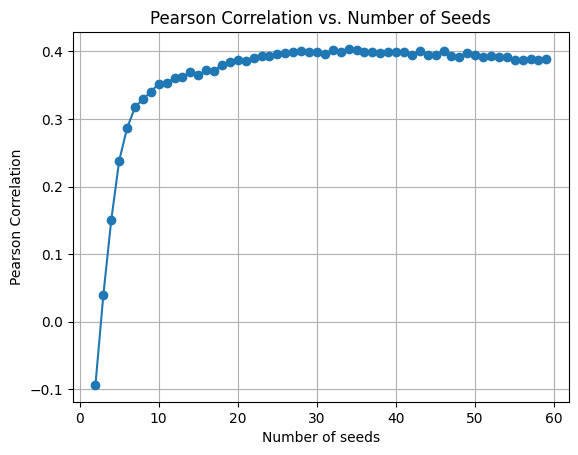

#### TESTING A VALUE: 8 ##########
#### TESTING B VALUE: 5 ##########
-3.0
[-1.3543870964243672, 0.08138204432076179, 0.32757895986668384, -0.9612296978200403, 1.617244619966172, -2.5660337968696876, 0.9127294510575528, 1.1470394412956537, 1.4590782558318125, -0.1521498941574313, 1.1006786822589665, 1.152893952953825, 1.5619999832321474, 1.4275543611105084, 0.3679041770580156, 1.5312542919202858, -0.7281603830410619, 0.3196298728829685, 0.2930305183900126, 2.5379790550635803, 3.490259085934819, 0.15242857042012403, 3.489020857811539, 3.626170127644033, 2.412409989622788, 5.0, 2.8726048652373875, 2.207182409667321, 3.390716474441116, 3.1368788779687193, -0.6182764894552832, 0.08949853433322819, 0.15653057285355043, 1.0607006521134914, 0.7104976660714746, 1.13760035726304, 1.7456688712909427, 1.9296884095584472, 0.34887302611297955, 1.9353044841326241, 0.9160817306881679, 0.8702961894508299, 0.9538589602086214, 0.544752831673418, 0.7777608127666769, 0.9411132301270948, -2.194866984172084

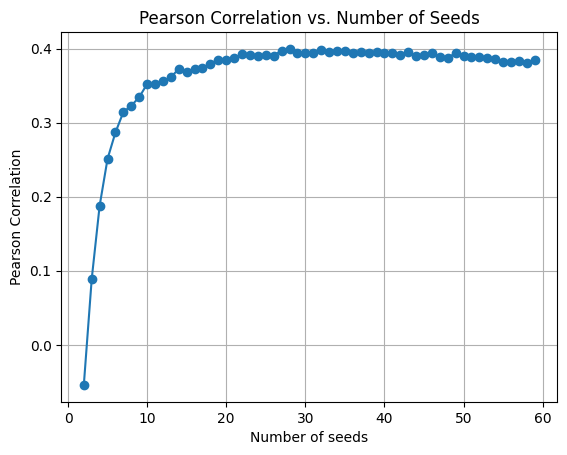

In [ ]:
#Grid Search: Best T1 parameters for linear scaling
a_values = [0.5,1,2,3,4,5,6,7,8]
b_values = [0,1,2,3,4,5]

for a in a_values:
  for b in b_values:
    print(f'#### TESTING A VALUE: {a} ##########')
    print(f'#### TESTING B VALUE: {b} ##########')
    thresholds_scaled = b - a*normalized_T1
    print(thresholds_scaled.min())
    if thresholds_scaled.min() > 1:
      continue
    if thresholds_scaled.max() < 1:
      continue
    thresholds_scaled = list(thresholds_scaled)
    print(thresholds_scaled)
    seed_comparison(G, FC_matrix, 100, 2, 60, thresholds=thresholds_scaled)

#### TESTING K VALUE: 5 ##########
#### TESTING MU VALUE: 0.5 ##########


<ipython-input-5-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


0.39213635364282423
35
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[np.float64(0.11606561621042932), np.float64(0.19324267812176318), np.float64(0.2277345954829614), np.float64(0.25323227078215516), np.float64(0.27042036361181887), np.float64(0.2892135315850788), np.float64(0.2996418854190547), np.float64(0.31839540824008516), np.float64(0.32807681423581225), np.float64(0.34066718575342536), np.float64(0.3431720950092978), np.float64(0.3440933033258907), np.float64(0.35676971517526407), np.float64(0.3604957658363756), np.float64(0.3638083295736662), np.float64(0.36434431547567325), np.float64(0.3682254497433523), np.float64(0.3786656487336085), np.float64(0.3740969416896596), np.float64(0.38088155307039095), np.float64(0.38218336

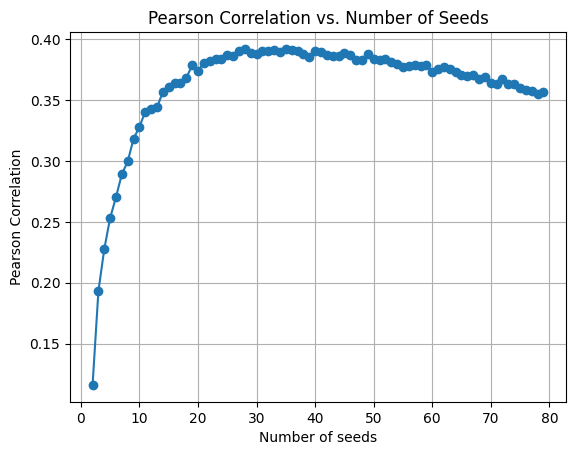

#### TESTING K VALUE: 5 ##########
#### TESTING MU VALUE: 0.6 ##########
0.3890510109051256
27
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[np.float64(0.11982097374600155), np.float64(0.18834537757309394), np.float64(0.21746448355776676), np.float64(0.2445447829848194), np.float64(0.26770688836346157), np.float64(0.28671173618738754), np.float64(0.29419180144537327), np.float64(0.3104569233257636), np.float64(0.3243056933921124), np.float64(0.33353320055383523), np.float64(0.3406457871433499), np.float64(0.34329395593676304), np.float64(0.3520888754989731), np.float64(0.35728195876809515), np.float64(0.3595205002146602), np.float64(0.3586975840081553), np.float64(0.36446514556364823), np.float64(0.37486079432789327), np.float64(0

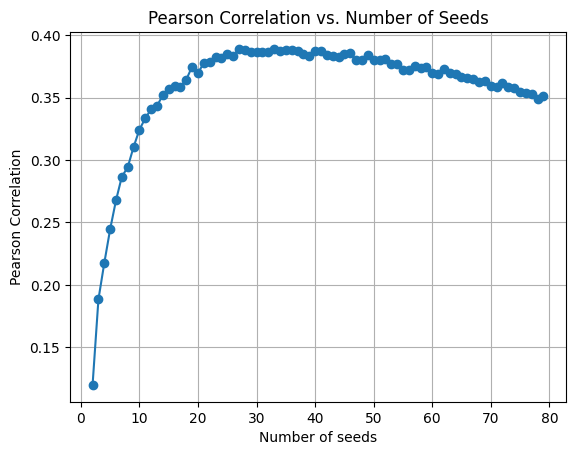

#### TESTING K VALUE: 5 ##########
#### TESTING MU VALUE: 0.7 ##########
0.388180500339316
35
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[np.float64(0.11522565640720521), np.float64(0.1789832553720717), np.float64(0.215389604888142), np.float64(0.23686721370490554), np.float64(0.25814773446323225), np.float64(0.28025322208010256), np.float64(0.28829132962901277), np.float64(0.30441239799026254), np.float64(0.3210253927315757), np.float64(0.32971779601246803), np.float64(0.3344463831922029), np.float64(0.3415118828417675), np.float64(0.34848833880195546), np.float64(0.35310398017234296), np.float64(0.3582288446102826), np.float64(0.35522313246163795), np.float64(0.3620275378629407), np.float64(0.3699210679568259), np.float64(0.36

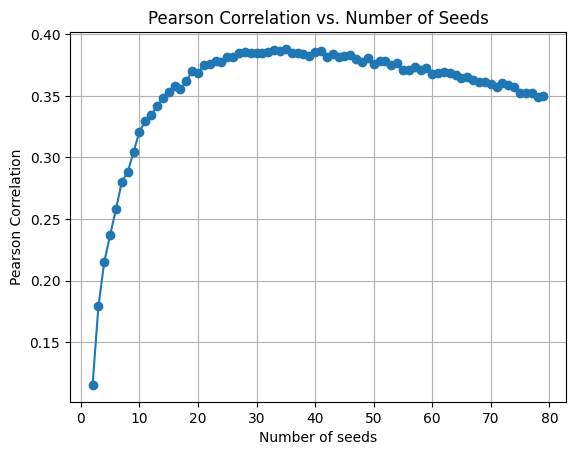

#### TESTING K VALUE: 10 ##########
#### TESTING MU VALUE: 0.5 ##########


In [ ]:
#Grid Search: Best parameters for T1 sigmoid scaling

#Grid search
k_vals = [5,10,20]
mu_vals = [0.5,0.6,0.7]

for k in k_vals:
  for mu in mu_vals:
    print(f'#### TESTING K VALUE: {k} ##########')
    print(f'#### TESTING MU VALUE: {mu} ##########')
    thresholds_sig = 4 - (4 / (1 + np.exp(-k * (normalized_T1 - mu))))
    if thresholds_sig.min() > 1:
      continue
    if thresholds_sig.max() < 1:
      continue
    thresholds_sig = list(thresholds_sig)
    seed_comparison(G, FC_matrix, 100, 2, 80, thresholds=thresholds_sig)

#### TESTING K VALUE: 10 ##########
#### TESTING MU VALUE: 0.5 ##########


<ipython-input-4-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


0.3952805109993993
28
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[np.float64(0.08230859917089872), np.float64(0.16278626598487592), np.float64(0.2057526598204806), np.float64(0.22833597623124402), np.float64(0.2536029092563601), np.float64(0.2770187954078111), np.float64(0.29620059265662574), np.float64(0.3135533779993914), np.float64(0.32865570344795525), np.float64(0.3331769377140042), np.float64(0.3404492659790571), np.float64(0.34312154566637126), np.float64(0.3571836944749569), np.float64(0.3602739865680924), np.float64(0.36463168028380044), np.float64(0.36577643752386885), np.float64(0.36927181421169725), np.float64(0.377863426331096), np.float64(0.3764491949860365), np.float64(0.38205406406820974), np.float64(0.3863987217

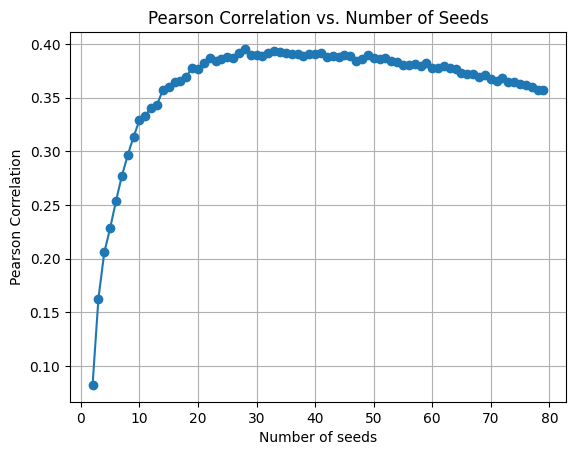

#### TESTING K VALUE: 10 ##########
#### TESTING MU VALUE: 0.6 ##########
0.38937555233692484
35
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[np.float64(0.08993785528263129), np.float64(0.1621488966154453), np.float64(0.20543696163180034), np.float64(0.22471472318309832), np.float64(0.24549943106120684), np.float64(0.2633742279137308), np.float64(0.28314530675465066), np.float64(0.29533847846141015), np.float64(0.3126777044011944), np.float64(0.32193835577276947), np.float64(0.32778425799777394), np.float64(0.33205542515388975), np.float64(0.34477357587976065), np.float64(0.34793547184969953), np.float64(0.35167778557496426), np.float64(0.34971397031678364), np.float64(0.36049637033467274), np.float64(0.3707802053263727), np.floa

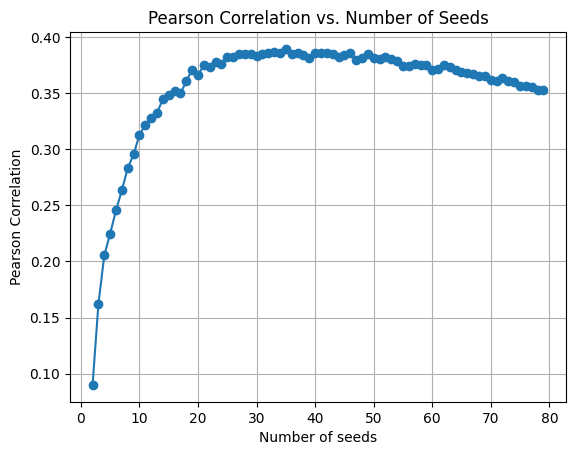

#### TESTING K VALUE: 10 ##########
#### TESTING MU VALUE: 0.7 ##########
0.38435238820832374
35
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[np.float64(0.09743022454832947), np.float64(0.1550966576046237), np.float64(0.19175306204683773), np.float64(0.22130514843533416), np.float64(0.24261905311649745), np.float64(0.26012891713755654), np.float64(0.27220825888804673), np.float64(0.2918418457003935), np.float64(0.30078868832007916), np.float64(0.3147250448370215), np.float64(0.3228112369748904), np.float64(0.3312455214837241), np.float64(0.3405113336194851), np.float64(0.34418740535520165), np.float64(0.3505531769948755), np.float64(0.3513018665478583), np.float64(0.35644343991491206), np.float64(0.3675654476836003), np.float64(0

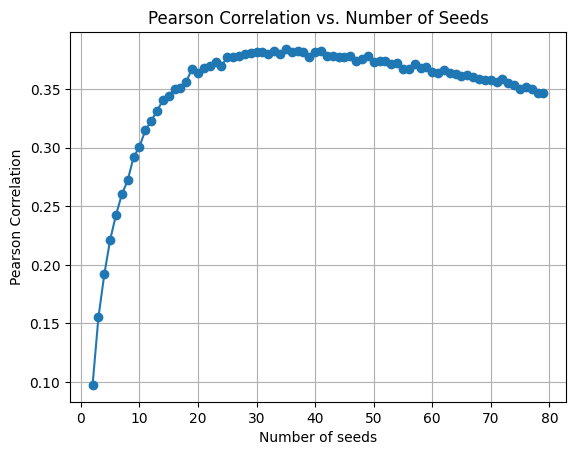

#### TESTING K VALUE: 20 ##########
#### TESTING MU VALUE: 0.5 ##########
0.3949351764802227
28
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[np.float64(0.07173134727657043), np.float64(0.15575867141884425), np.float64(0.20288947530949936), np.float64(0.24000841246858312), np.float64(0.25731737473405747), np.float64(0.2851699633283567), np.float64(0.3011241306570165), np.float64(0.3178610926888587), np.float64(0.3353367330208537), np.float64(0.33819863570188086), np.float64(0.33872251092190186), np.float64(0.34693369794720386), np.float64(0.36144545383619187), np.float64(0.35699716819367106), np.float64(0.3623802258047674), np.float64(0.3638854724758287), np.float64(0.37191752579318343), np.float64(0.37699533207395314), np.float64

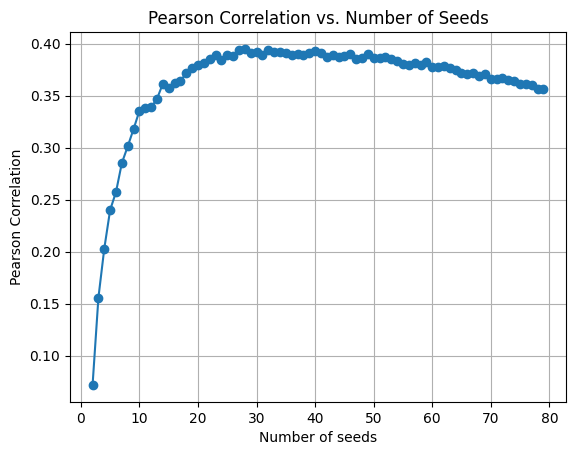

#### TESTING K VALUE: 20 ##########
#### TESTING MU VALUE: 0.6 ##########
0.38303381890918115
35
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[np.float64(0.06347225174702746), np.float64(0.13039838758599154), np.float64(0.18085470916743962), np.float64(0.20419997108298996), np.float64(0.23221275150612541), np.float64(0.25580575220823293), np.float64(0.27661238870933996), np.float64(0.2925891065055978), np.float64(0.3105135200219546), np.float64(0.3122665762672585), np.float64(0.3197134406775536), np.float64(0.3284055443551983), np.float64(0.3405435451342021), np.float64(0.3409151634358998), np.float64(0.3447387203307389), np.float64(0.346947814205041), np.float64(0.35457283353861196), np.float64(0.3631230058744722), np.float64(0.3

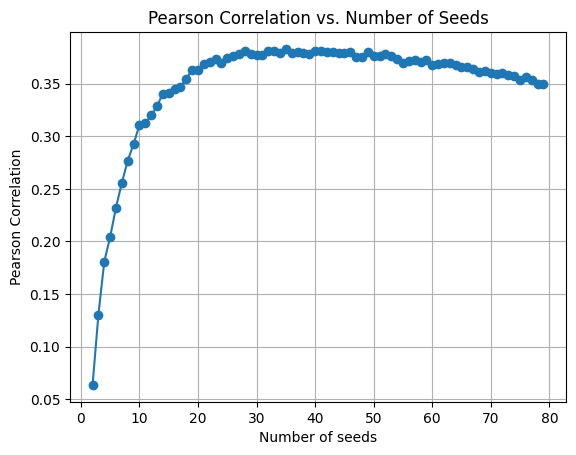

#### TESTING K VALUE: 20 ##########
#### TESTING MU VALUE: 0.7 ##########
0.3821187458186099
33
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[np.float64(0.07806082277810161), np.float64(0.13342496589483158), np.float64(0.17409506209135656), np.float64(0.19945763120594576), np.float64(0.22311298789747935), np.float64(0.2474470463900841), np.float64(0.2617076229277024), np.float64(0.2814458395738691), np.float64(0.2925634963234448), np.float64(0.3031395987307565), np.float64(0.3140436371307931), np.float64(0.3190346102021751), np.float64(0.3323050256625793), np.float64(0.33733813054913253), np.float64(0.3428767879810356), np.float64(0.340526896623056), np.float64(0.34837111363150214), np.float64(0.35816228096487307), np.float64(0.35

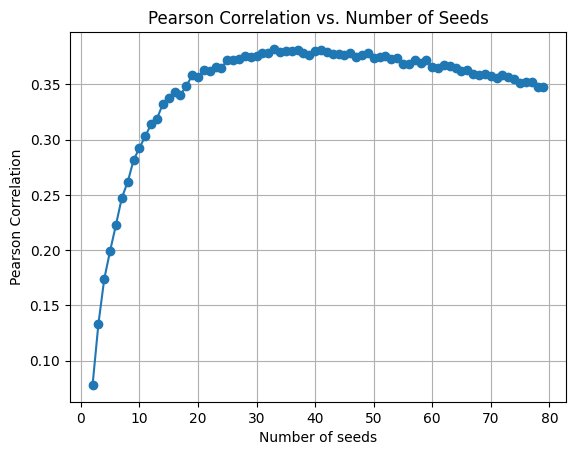

In [ ]:
#Continuing grid search post disconnect
k_vals = [10,20]
mu_vals = [0.5,0.6,0.7]
for k in k_vals:
  for mu in mu_vals:
    print(f'#### TESTING K VALUE: {k} ##########')
    print(f'#### TESTING MU VALUE: {mu} ##########')
    thresholds_sig = 4 - (4 / (1 + np.exp(-k * (normalized_T1 - mu))))
    if thresholds_sig.min() > 1:
      continue
    if thresholds_sig.max() < 1:
      continue
    thresholds_sig = list(thresholds_sig)
    seed_comparison(G, FC_matrix, 100, 2, 80, thresholds=thresholds_sig)

<ipython-input-4-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


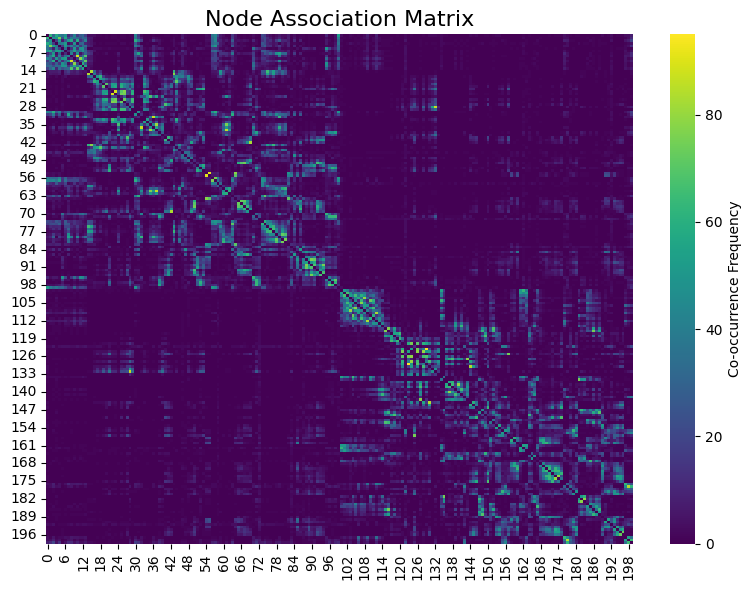

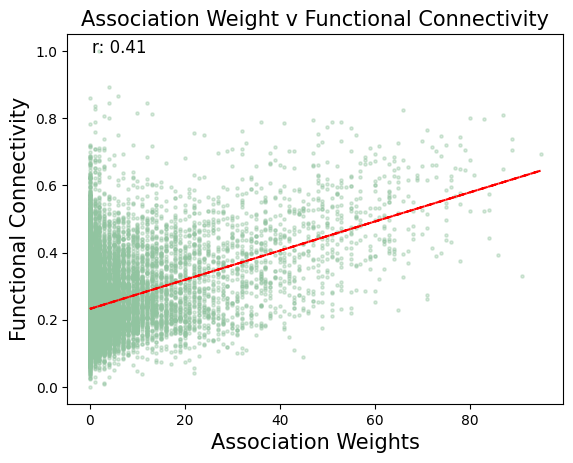

In [ ]:
from scipy.stats import pearsonr

#Best model
adj_matrix= np.array(NoSdf)
FC_matrix = np.array(group_FCdf)
adj_matrix_zscore = (adj_matrix - np.mean(adj_matrix)) / np.std(adj_matrix)
G = nx.from_numpy_array(adj_matrix_zscore, create_using=nx.DiGraph())
thresholds_scaled = 2-3*normalized_T1
thresholds_scaled = list(thresholds_scaled)

final_activations = run_simulations(G, 28, 100, thresholds=thresholds_scaled) #28 best seeds
association_matrix = compute_association_matrix(G, final_activations)
plot_association_matrix(association_matrix, G)

#Plot scatterplot between values in the association matrix and FC_matrix_LH
x = association_matrix.flatten()

#Min max normalize FC matrix
FC_matrix = (FC_matrix - FC_matrix.min()) / (FC_matrix.max() - FC_matrix.min())
y = FC_matrix.flatten()

#Compute the Pearson correlation
corr, _ = pearsonr(x, y)

#Create a scatter plot
plt.scatter(x, y, alpha=0.2, s=5, color='#91c4a0')
#Add a line of best fit and pearson correlation value
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

#print pearson correlation value on graph
plt.text(0.05, 0.95, f'r: {corr:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('Association Weights', fontsize=15)
plt.ylabel('Functional Connectivity',fontsize=15)
plt.title('Association Weight v Functional Connectivity',fontsize=15)
plt.show()


**T1 modulated LTM Left Hemisphere**

<ipython-input-4-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


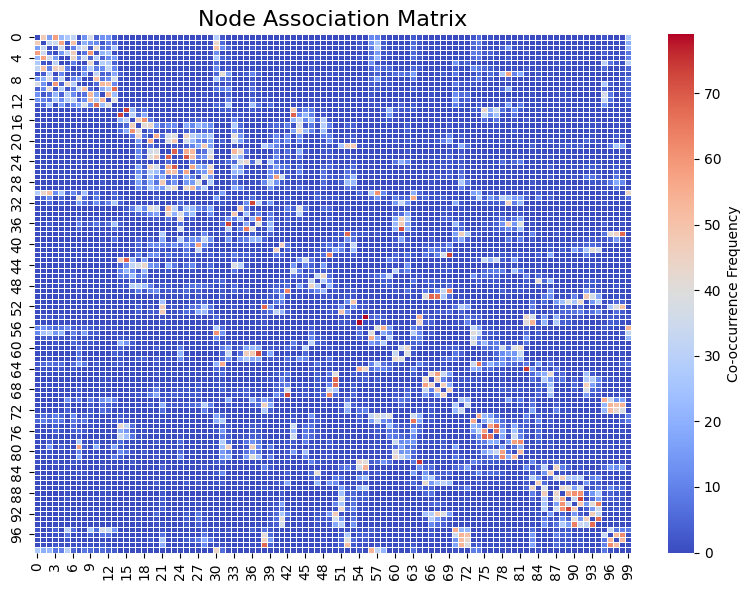

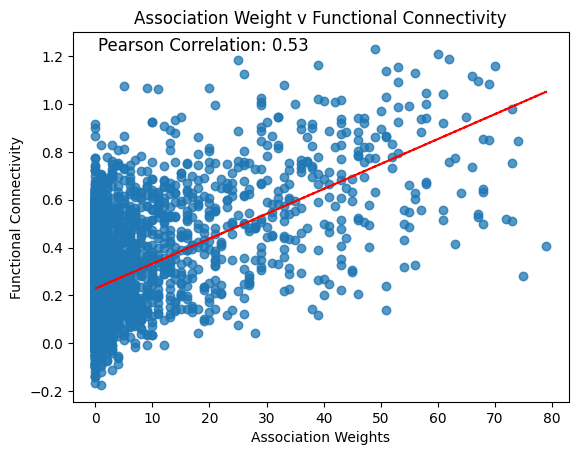

In [ ]:
from scipy.stats import pearsonr

#Left Hemipshere: Heterogeneous model
#Extract LH adjacency matrix and FC
adj_matrix= np.array(NoSdf)
FC_matrix = np.array(group_FCdf)

#Splice adj matrix to have only first 100 values
adj_matrix_LH = adj_matrix[:100, :100]
FC_matrix_LH = FC_matrix[:100, :100]

adj_matrix_zscore_LH = (adj_matrix_LH - np.mean(adj_matrix_LH)) / np.std(adj_matrix_LH)

#Turn the binarized array into a graph
G = nx.from_numpy_array(adj_matrix_LH, create_using=nx.DiGraph())
#Association weight values
thresholds_scaled = 2-3*normalized_T1
thresholds_scaled = list(thresholds_scaled)
final_activations = run_simulations(G, 28, 100, thresholds=thresholds_scaled) #28 best seeds
association_matrix = compute_association_matrix(G, final_activations)
plot_association_matrix(association_matrix, G)

#Plot scatterplot between values in the association matrix and FC_matrix_LH
x = association_matrix.flatten()
y = FC_matrix_LH.flatten()

#Compute the Pearson correlation
corr, _ = pearsonr(x, y)

#Create a scatter plot
plt.scatter(x, y, alpha=0.5)
#Add a line of best fit and pearson correlation value
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

#print pearson correlation value on graph
plt.text(0.05, 0.95, f'Pearson Correlation: {corr:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('Association Weights')
plt.ylabel('Functional Connectivity')
plt.title('Association Weight v Functional Connectivity')
plt.show()

**T1 modulated Right Hemisphere**

<ipython-input-4-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


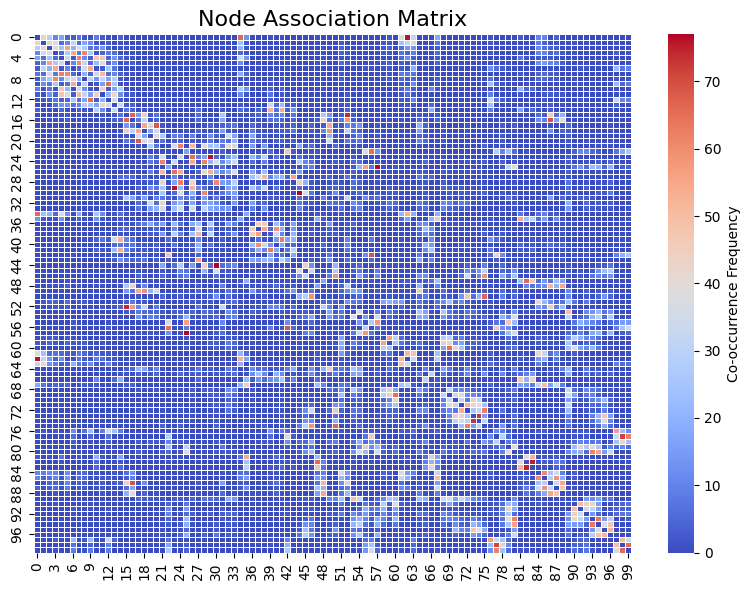

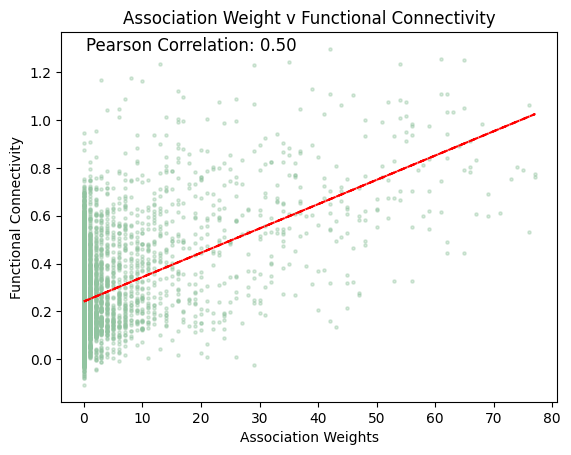

In [ ]:
#Right Hemisphere: Heterogeneous model#Extract RH adjacency matrix and FC
adj_matrix= np.array(NoSdf)
FC_matrix = np.array(group_FCdf)

#Splice adj matrix to have only last 100 values
adj_matrix_RH = adj_matrix[-100:, -100:]
FC_matrix_RH = FC_matrix[-100:, -100:]

adj_matrix_zscore_RH = (adj_matrix_RH - np.mean(adj_matrix_RH)) / np.std(adj_matrix_RH)

#Turn the binarized array into a graph
G = nx.from_numpy_array(adj_matrix_RH, create_using=nx.DiGraph())

final_activations = run_simulations(G, 28, 100, thresholds=thresholds_scaled)
association_matrix = compute_association_matrix(G, final_activations)
plot_association_matrix(association_matrix, G)

#Plot scatterplot between values in the association matrix and FC_matrix_LH
x = association_matrix.flatten()
y = FC_matrix_RH.flatten()

#Compute the Pearson correlation
corr, _ = pearsonr(x, y)

#Create a scatter plot
plt.scatter(x, y, alpha=0.2, s=5, color='#91c4a0')
#Add a line of best fit and pearson correlation value
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

#print pearson correlation value on graph
plt.text(0.05, 0.95, f'Pearson Correlation: {corr:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('Association Weights')
plt.ylabel('Functional Connectivity')
plt.title('Association Weight v Functional Connectivity')
plt.show()



**Comparing homogeneous and heterogeneous LTM**

In [ ]:
#Comparison of Homogenous and Heterogeneous model

#Heterogeneous model
final_activations = run_simulations(G, 28, 100, thresholds=thresholds_scaled) #28 best seeds
association_matrix = compute_association_matrix(G, final_activations)

#Homogenous model
final_activations = run_simulations(G, 35, 100, thresholds=None)
association_matrix2 = compute_association_matrix(G, final_activations)

association_matrix = association_matrix.flatten()
association_matrix2 = association_matrix2.flatten()

#Compute correlation between 2 association weight matrices
corr, _ = pearsonr(association_matrix, association_matrix2)
print(corr)


<ipython-input-4-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


0.9474630946172442


In [ ]:
#Comparison of Homogeneous and Heterogenous model at the Network Level

#Heterogeneous model
final_activations = run_simulations(G, 28, 100, thresholds=thresholds_scaled) #28 best seeds
association_matrix = compute_association_matrix(G, final_activations)

#Homogenous model
final_activations = run_simulations(G, 35, 100, thresholds=None)
association_matrix2 = compute_association_matrix(G, final_activations)

#Functional connectivity indices mapping
# 'Limbic': [55,56,57,58,59,60],
LH_FC_map = {
    'Vis': [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
    'SomMot': [15,12,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
    'DorsAttn': [31,32,33,34,35,36,37,38,39,40,41,42,43],
    'SalVentAttn': [44,45,46,47,48,49,50,51,52,53,54],
    'Cont': [61,62,63,64,65,66,67,68,69,70,71,72,73],
    'Default': [74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100]
}

#'Limbic': [159,160,161,162,163,164],
RH_FC_map = {
    'Vis': [101,102,103,104,105,106,107,108,109,110,111,112,113,114, 115],
    'SomMot': [116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134],
    'DorsAttn': [135,136,137,138,139,140, 141,142,143,144,145,146,147],
    'SalVentAttn': [148,149,150,151,152,153,154,155,156,157,158],
    'Cont': [165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181],
    'Default': [182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200]
}

FC_map = {}

# Merge LH and RH maps
for network in set(LH_FC_map.keys()).union(RH_FC_map.keys()):
    FC_map[network] = LH_FC_map.get(network, []) + RH_FC_map.get(network, [])


#Redefine FC matrix
FC_matrix = np.array(group_FCdf)

#Min-max normalize FC matrix
FC_matrix = (FC_matrix - FC_matrix.min()) / (FC_matrix.max() - FC_matrix.min())

#For each functional network (based on mapping) compute pearson correlation between
#Association weight matrices and FC
#Plot both associaiton matrices correlations/network side by side on a bar graph


<ipython-input-4-bad9ee5560eb>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_groups)  # 'tab10' is good for distinct categories; change as needed


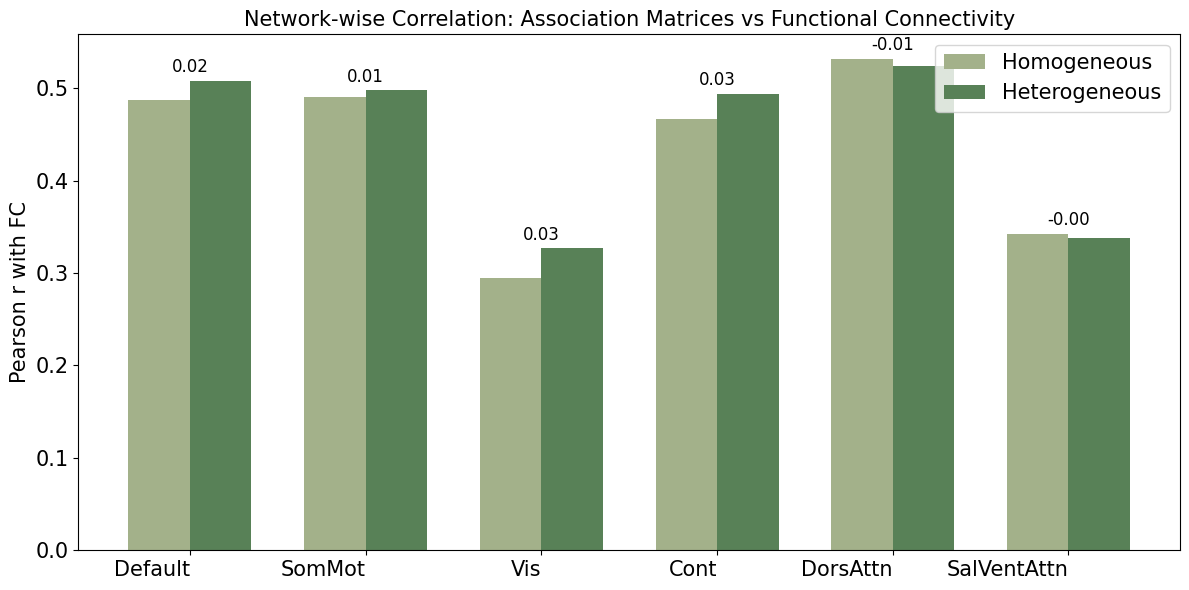

In [ ]:
# Function to get upper triangle values (excluding diagonal)
def get_upper_triangle_values(matrix, indices):
    indices = [i - 1 for i in indices]  # Shift to 0-based indexing
    sub = matrix[np.ix_(indices, indices)]
    triu_idx = np.triu_indices_from(sub, k=1)
    return sub[triu_idx]

# Store correlations
network_labels = list(FC_map.keys())
hetero_corrs = []
homo_corrs = []

for network in network_labels:
    indices = FC_map[network]

    # Get vectorized upper triangle for each matrix
    fc_vals = get_upper_triangle_values(FC_matrix, indices)
    hetero_vals = get_upper_triangle_values(association_matrix, indices)
    homo_vals = get_upper_triangle_values(association_matrix2, indices)

    # Compute Pearson correlations
    r_hetero, _ = pearsonr(fc_vals, hetero_vals)
    r_homo, _ = pearsonr(fc_vals, homo_vals)

    hetero_corrs.append(r_hetero)
    homo_corrs.append(r_homo)

# --- Plotting ---
x = np.arange(len(network_labels))
width = 0.35
sage_light = '#A3B18A'
sage_dark = '#588157'

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, homo_corrs, width, label='Homogeneous', color=sage_light)
bars2 = ax.bar(x + width/2, hetero_corrs, width, label='Heterogeneous', color=sage_dark)

# Annotate differences
for i, (homo, hetero) in enumerate(zip(homo_corrs, hetero_corrs)):
    diff = hetero - homo
    y = max(homo, hetero)
    ax.text(i, y + 0.005, f'{diff:.2f}', ha='center', va='bottom', fontsize=12)

ax.set_ylabel('Pearson r with FC', fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title('Network-wise Correlation: Association Matrices vs Functional Connectivity', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(network_labels, ha='right', fontsize=15)
ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

**Exporting LTM matrix as CSV to include in multilinear models**

See feature_similarity.ipynb for multilinear models.

In [ ]:
#save linear threshold network (hetero)out to google drive
df = pd.DataFrame(association_matrix)

# Specify the path where you want to save the file in your Google Drive
file_path = '/content/drive/My Drive/association_matrix_output.csv'

# Save the DataFrame to CSV
df.to_csv(file_path, index=False)